In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#from pathlib import Path
import sys
import os
import argparse
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
sys.path.append('../')
import json
from pathlib import Path
from log import logger
import logging
#from lib.io.loadConfigs import *
import lib.io.loadConfigs as loadConfigs
import lib.io.readPollyRawData as readPollyRawData
import lib.interface.picassoProc as picassoProc
import lib.misc.helper as helper
import lib.misc.startscreen as startscreen
import lib.misc.json2nc_mapping as json2nc_mapping

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from scipy.ndimage import uniform_filter1d

# Helper functions
def smooth_signal(signal, window_len):
    return uniform_filter1d(signal, size=window_len, mode='nearest')


In [77]:
## getting root dir of PicassoPy
root_dir0 = Path(os.path.abspath('')).resolve().parent
root_dir = helper.detect_path_type(root_dir0)

print(root_dir0)
print(root_dir)

## setting config files
picasso_default_config_file = Path(root_dir,'lib','config','pollynet_processing_chain_config.json')
print(picasso_default_config_file)
polly_default_config_file = Path(root_dir,'lib','config','polly_global_config.json')
print(polly_default_config_file)
#picasso_config_file = "/pollyhome/Bildermacher2/experimental/PicassoPy/config/pollynet_processing_chain_config_rsd2_24h_exp.json"
polly_default_global_defaults_file = Path(root_dir,'lib','config','polly_global_defaults.json')
print(polly_default_global_defaults_file)


/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config.json
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_config.json
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_defaults.json


In [78]:
# for purpose of the notebook mimic the argparse interface
from types import SimpleNamespace
args = SimpleNamespace()

args.timestamp = '20230618'
args.device = 'arielle'

args.picasso_config_file = "/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config_interface.json"
args.level0_file_to_process = "../../../../localdata/coala/arielle_24h/2023_06_18_Sun_ARI_00_00_01.nc"

In [6]:
import pprint

In [81]:
## start_screen
startscreen.startscreen()

## loading configs as dicts
picasso_config_dict = loadConfigs.loadPicassoConfig(args.picasso_config_file,picasso_default_config_file)
pprint.pprint(picasso_config_dict)
polly_config_array = loadConfigs.readPollyNetConfigLinkTable(picasso_config_dict['pollynet_config_link_file'],timestamp=args.timestamp,device=args.device)
polly_config_file = str(polly_config_array['Config file'].to_string(index=False)).strip()
polly_device = str(polly_config_array['Instrument'].to_string(index=False)).strip()
polly_location = str(polly_config_array['Location'].to_string(index=False)).strip()
polly_asl = str(polly_config_array['asl.'].to_string(index=False)).strip()
polly_default_file = str(polly_config_array['Default file'].to_string(index=False)).strip()

output_path = Path(picasso_config_dict["fileinfo_new"]).parent


if polly_config_file:
    polly_config_file_fullname = Path(picasso_config_dict['polly_config_folder'],polly_config_file)
else:
    polly_config_file_fullname = polly_default_config_file
if polly_default_file:
    polly_default_file_fullname = Path(picasso_config_dict['defaultFile_folder'],polly_default_file)
else:
    polly_default_file_fullname = polly_default_global_defaults_file

print("polly_config_file_fullname", polly_config_file_fullname)
print("polly_default_config_file", polly_default_config_file)
print("polly_config_file", polly_config_file)
print("polly_default_file", polly_default_file)

polly_config_dict = loadConfigs.loadPollyConfig(polly_config_file_fullname, polly_default_config_file)
## adding some information from pollynet_config_link_file (xlsx-file) to polly_config_dict
polly_config_dict['name'] = polly_device
polly_config_dict['site'] = polly_location
polly_config_dict['asl'] = polly_asl

polly_default_dict = loadConfigs.loadPollyConfig(polly_default_file_fullname, polly_default_global_defaults_file)

2025-01-06 15:53:00,792 - INFO - picasso_default_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config.json
2025-01-06 15:53:00,798 - INFO - picasso_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config_interface.json
2025-01-06 15:53:00,805 - INFO - pollynet_config_link_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config_links.xlsx
2025-01-06 15:53:00,828 - INFO - polly_default_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_config.json
2025-01-06 15:53:00,834 - INFO - polly_config_file: /mnt/c/Users/radenz/dev/picasso-nb-interface/configs/pollyConfigs/arielle_config_20230101.json
2025-01-06 15:53:00,841 - INFO - polly_default_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_defaults.json
2025-01-06 15:53:00,844 - WARNING - polly_config_file: /home/matlab/picasso-nb-interface/configs/pol

      ____  _                            ____           ___ ____ 
     / __ \(_)________ _______________  / __ \__  __   <  // __ \
    / /_/ / / ___/ __ `/ ___/ ___/ __ \/ /_/ / / / /   / // / / /
   / ____/ / /__/ /_/ (__  |__  ) /_/ / ____/ /_/ /   / // /_/ / 
  /_/   /_/\___/\__,_/____/____/\____/_/    \__, /   /_(_)____/  
                                           /____/                
{'MWRFolder': '/home/hatpro/data/nmy/data/level2/',
 'contact': 'Holger Baars <baars@tropos.de>',
 'defaultFile_folder': '/home/matlab/picasso-nb-interface/configs/pollyDefaults',
 'doneListFile': '/home/matlab/Pollynet_Processing_Chain/run_lists/done_filelist_playground.txt',
 'figDPI': 80,
 'fileinfo_new': '/home/matlab/Pollynet_Processing_Chain/run_lists/fileinfo_playground.txt',
 'flagDebugOutput': False,
 'flagDeleteData': False,
 'flagDeletePreOutputs': True,
 'flagEnableCaliResultsOutput': True,
 'flagEnableDataVisualization': False,
 'flagEnableDataVisualization24h': True,
 'flagEnableResu

In [8]:
rawfile_fullname = args.level0_file_to_process
print(rawfile_fullname)
rawfile = helper.detect_path_type(rawfile_fullname)

../../../../localdata/coala/arielle_24h/2023_06_18_Sun_ARI_00_00_01.nc


In [9]:
rawdata_dict = readPollyRawData.readPollyRawData(filename=rawfile)

## initate picasso-object from class PicassoProc
data_cube = picassoProc.PicassoProc(rawdata_dict,polly_config_dict,picasso_config_dict)


2025-01-06 13:43:36,474 - INFO - reading nc-file: ../../../../localdata/coala/arielle_24h/2023_06_18_Sun_ARI_00_00_01.nc


In [10]:
print(data_cube.polly_config_dict['dtCorMode'])
print(data_cube.polly_config_dict['flagDTCor'])

data_cube.polly_config_dict['flagDTCor'] = True

1
True


In [11]:
#print(data_cube.device)
#print(data_cube.location)
#print(data_cube.date)

## reset date if date in filename differs date within nc-file 
data_cube.reset_date_infile()

## checking for correct mshots
data_cube.check_for_correct_mshots()
#print(data_cube.filter_or_correct_false_mshots())

## setting channelTags
data_cube.setChannelTags()
#print(data_cube.polly_config_dict['channelTags'])
#print(data_cube.channel_dict)

## check for correct date in nc-file
data_cube.reset_date_infile()

## preprocessing
data_cube.preprocessing()
#print(data_cube.rawdata_dict.keys())
#print(data_cube.data_retrievals.keys())

2025-01-06 13:43:45,969 - INFO - date consistency-check... 
2025-01-06 13:43:45,971 - INFO - ... date in nc-file equals date of filename
2025-01-06 13:43:45,984 - INFO - ChannelLabels: ['FR-total-355 nm', 'FR-cross-355 nm', 'FR-387 nm', 'FR-407 nm', 'FR-total-532 nm', 'FR-cross-532 nm', 'FR-607 nm', 'FR-total-1064 nm', 'NR-total-532 nm', 'NR-607 nm', 'NR-total-355 nm', 'NR-387 nm']
2025-01-06 13:43:45,986 - INFO - date consistency-check... 
2025-01-06 13:43:45,987 - INFO - ... date in nc-file equals date of filename
2025-01-06 13:43:45,990 - INFO - starting data preprocessing...
2025-01-06 13:43:45,993 - INFO - ... time conversion
2025-01-06 13:43:46,010 - INFO - ... Deadtime-correction (Mode: 1)
2025-01-06 13:46:24,893 - INFO - ... removing background from signal
2025-01-06 13:46:40,203 - INFO - ... height bin calculations
2025-01-06 13:46:40,418 - INFO - ... mask bins with low SNR
2025-01-06 13:47:13,056 - INFO - ... mask for polarization calibration
2025-01-06 13:47:13,200 - INFO - 

(2880, 3000, 13)
ranges2d (2880, 3000)


2025-01-06 13:47:25,055 - INFO - finished data preprocessing.


In [12]:
import pickle
with open('sig_40_140.pickle', 'rb') as f:
    comp_ml = pickle.load(f)

print(comp_ml.keys())

dict_keys(['sig532t_40_140', 'sig532c_40_140', 'rawsig532t_40_140', 'rawsig532c_40_140', 'sigDTcor_532t_40_140', 'sigDTcor_532c_40_140'])


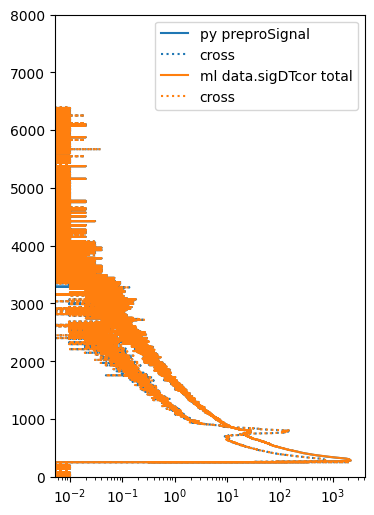

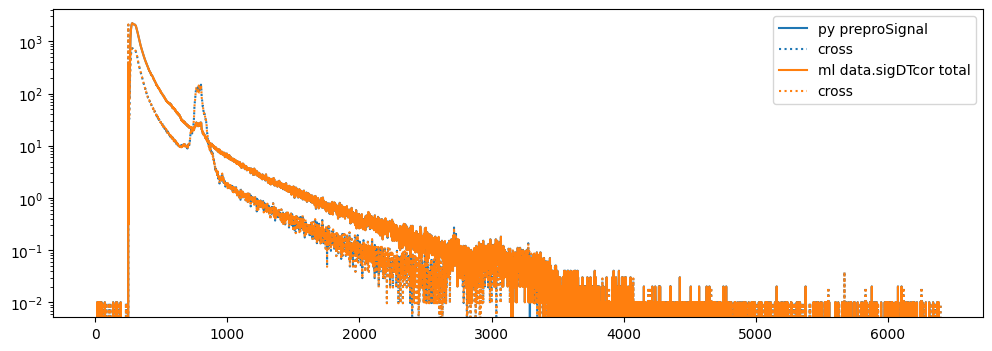

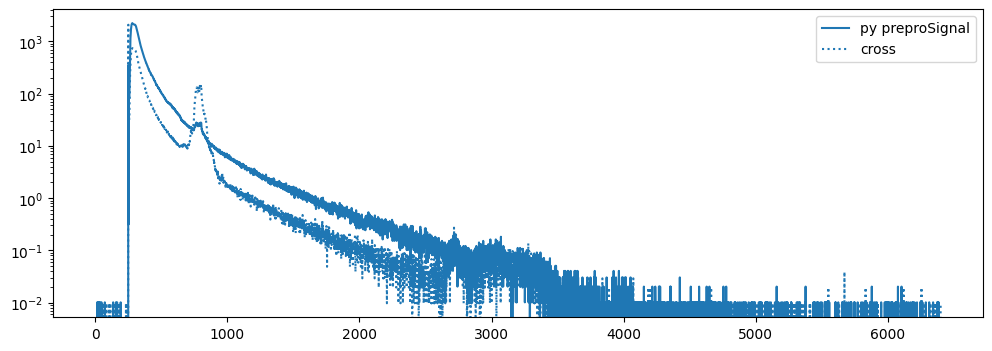

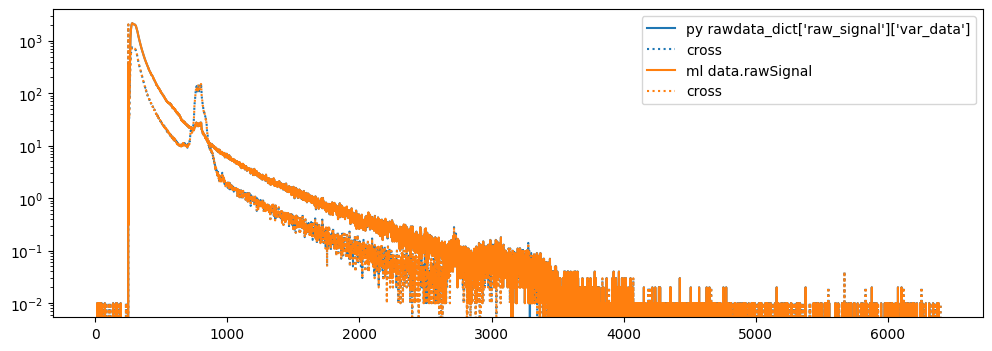

In [13]:
m_preproSig_532_total = np.mean(data_cube.data_retrievals['preproSignal'][39:139,:,4], axis=0)
m_preproSig_532_cross = np.mean(data_cube.data_retrievals['preproSignal'][39:139,:,5], axis=0)

fig, ax = plt.subplots(1, figsize=(4, 6))
ax.plot(m_preproSig_532_total, np.arange(6400), color='C0', label='py preproSignal')
ax.plot(m_preproSig_532_cross, np.arange(6400), color='C0', ls=':', label='cross')

ax.plot(comp_ml['sigDTcor_532t_40_140'], np.arange(6400), color='C1', label='ml data.sigDTcor total')
ax.plot(comp_ml['sigDTcor_532c_40_140'], np.arange(6400), color='C1', ls=':', label='cross')

ax.set_ylim(0, 8000)
ax.set_xscale('log')
ax.legend()

fig, ax = plt.subplots(1, figsize=(12,4))
ax.plot(m_preproSig_532_total, color='C0', label='py preproSignal')
ax.plot(m_preproSig_532_cross, color='C0', ls=':', label='cross')

ax.plot(comp_ml['sigDTcor_532t_40_140'], color='C1', label='ml data.sigDTcor total')
ax.plot(comp_ml['sigDTcor_532c_40_140'], color='C1', ls=':', label='cross')

ax.set_yscale('log')
ax.legend()

fig, ax = plt.subplots(1, figsize=(12,4))
ax.plot(m_preproSig_532_total, color='C0', label='py preproSignal')
ax.plot(m_preproSig_532_cross, color='C0', ls=':', label='cross')

ax.set_yscale('log')
ax.legend()

rawsig_532_total = np.mean(data_cube.rawdata_dict['raw_signal']['var_data'][39:139,:,4], axis=0)
rawsig_532_cross = np.mean(data_cube.rawdata_dict['raw_signal']['var_data'][39:139,:,5], axis=0)
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(rawsig_532_total, color='C0', label="py rawdata_dict['raw_signal']['var_data']")
ax.plot(rawsig_532_cross, color='C0', ls=':', label='cross')

ax.plot(comp_ml['rawsig532t_40_140'], color='C1', label='ml data.rawSignal')
ax.plot(comp_ml['rawsig532c_40_140'], color='C1', ls=':', label='cross')

# ax.plot(comp_ml['readrawsig532t_40_140'], color='C2', label='ml read data.rawSignal')
# ax.plot(comp_ml['readrawsig532c_40_140'], color='C2', ls=':', label='cross')


# ax.set_ylim(0, 6000)
ax.set_yscale('log')
ax.legend()

In [14]:
len(data_cube.data_retrievals['time'])

2880

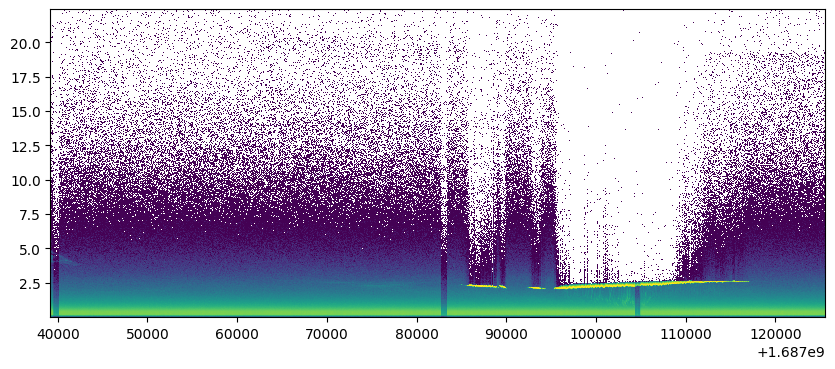

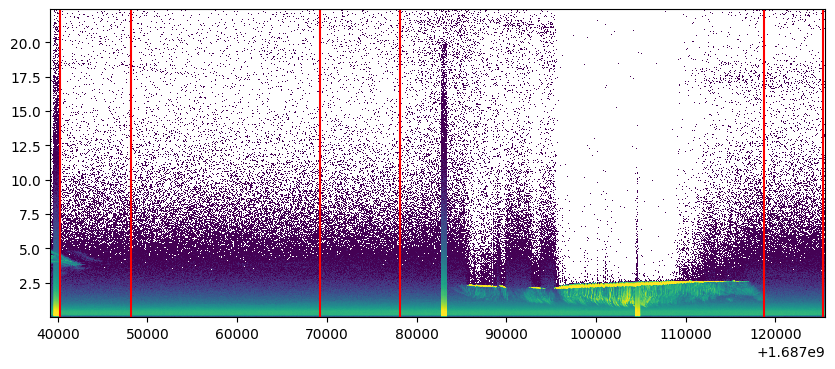

In [15]:
fig, ax = plt.subplots(1, figsize=(10, 4))
pcmesh = ax.pcolormesh(
    data_cube.data_retrievals['time'], np.array(data_cube.data_retrievals['height'])/1000, 
    data_cube.data_retrievals['sigBGCor'][:,:,4].T, shading='nearest',
    norm=matplotlib.colors.LogNorm(vmin=5, vmax=1e4),
    )

fig, ax = plt.subplots(1, figsize=(10, 4))
pcmesh = ax.pcolormesh(
    data_cube.data_retrievals['time'], np.array(data_cube.data_retrievals['height'])/1000, 
    data_cube.data_retrievals['sigBGCor'][:,:,5].T, shading='nearest',
    norm=matplotlib.colors.LogNorm(vmin=5, vmax=1e4),
    )

ax.axvline(data_cube.data_retrievals['time'][35], color='r')
ax.axvline(data_cube.data_retrievals['time'][300], color='r')

ax.axvline(data_cube.data_retrievals['time'][1000], color='r')
ax.axvline(data_cube.data_retrievals['time'][1300], color='r')

ax.axvline(data_cube.data_retrievals['time'][2650], color='r')
ax.axvline(data_cube.data_retrievals['time'][2870], color='r')

# ax.set_ylim(top=6)
# cbar = fig.colorbar(pcmesh)
# ax.set_xlabel(f"Time", fontsize=10)
# ax.set_ylabel("Height [km]", fontsize=10)
# cbar.ax.set_ylabel(f"Signal Ch. {ich} ({picassointerface.short_label(channel_labels[ich])})", fontsize=10)
# ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
# ax.xaxis.set_major_locator(matplotlib.dates.HourLocator(interval=3))
# ax.xaxis.set_minor_locator(matplotlib.dates.MinuteLocator(byminute=[0,15,30,45]))
# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

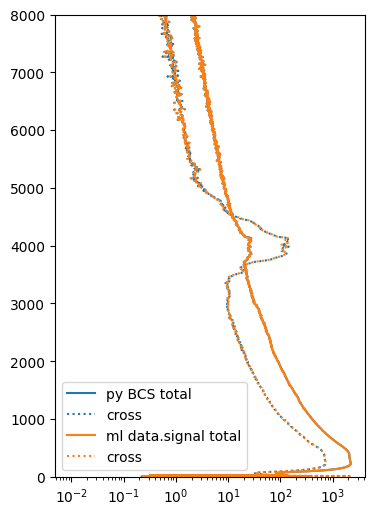

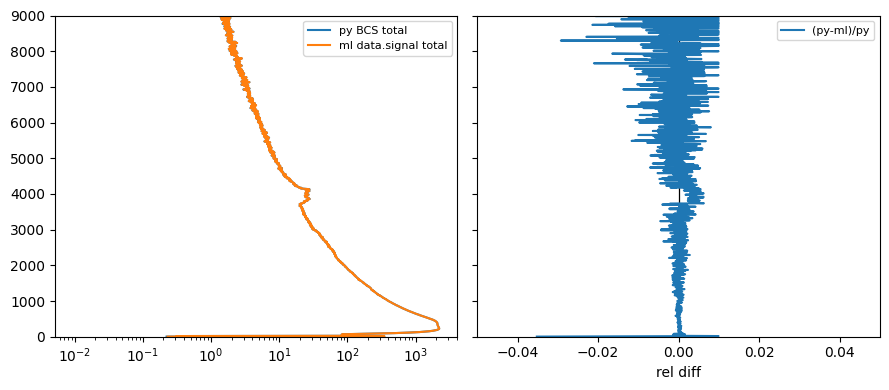

In [16]:
mean_532_total = np.mean(data_cube.data_retrievals['sigBGCor'][39:139,:,4], axis=0)
mean_532_cross = np.mean(data_cube.data_retrievals['sigBGCor'][39:139,:,5], axis=0)

fig, ax = plt.subplots(1, figsize=(4, 6))
ax.plot(mean_532_total, np.array(data_cube.data_retrievals['height']), color='C0', label='py BCS total')
ax.plot(mean_532_cross, np.array(data_cube.data_retrievals['height']), color='C0', ls=':', label='cross')

ax.plot(comp_ml['sig532t_40_140'], np.array(data_cube.data_retrievals['height']), color='C1', label='ml data.signal total')
ax.plot(comp_ml['sig532c_40_140'], np.array(data_cube.data_retrievals['height']), color='C1', ls=':', label='cross')

ax.set_ylim(0, 8000)
ax.set_xscale('log')
ax.legend()



fig, (ax, ax1) = plt.subplots(1,2, figsize=(9,4), sharey=True)
ax.plot(mean_532_total, np.array(data_cube.data_retrievals['height']), color='C0', label='py BCS total')
ax.plot(comp_ml['sig532t_40_140'], np.array(data_cube.data_retrievals['height']), color='C1', label='ml data.signal total')

ax.set_ylim(0, 9000)
ax.set_xscale('log')
ax.legend(fontsize=8)

reldiff = (mean_532_total - comp_ml['sig532t_40_140'])/mean_532_total
ax1.axvline(0, lw=0.9, color='k')
ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
ax1.legend(fontsize=8)
ax1.set_xlim(-0.05, 0.05); ax1.set_xlabel('rel diff')
fig.tight_layout()
# # fig.savefig('mSig_rayleigh_fit.png')
# print('mSig', mSig[:20])


In [17]:
# data_cube.rawdata_dict['raw_signal']['var_data'].shape


In [18]:
print(data_cube.rawdata_dict.keys())

dict_keys(['filename', 'global_attributes', 'raw_signal', 'measurement_shots', 'measurement_time', 'depol_cal_angle', 'measurement_height_resolution', 'laser_rep_rate', 'laser_power', 'laser_flashlamp', 'location_height', 'location_coordinates', 'neutral_density_filter', 'if_center', 'if_fwhm', 'polstate', 'telescope', 'deadtime_polynomial', 'deadtime_polynomial_error', 'discr_level', 'pm_voltage', 'pinhole', 'zenithangle'])


In [19]:
print(data_cube.data_retrievals.keys())

dict_keys(['channel', 'PCR_cor', 'PCR_slice', 'preproSignal', 'BG', 'sigBGCor', 'height', 'range', 'alt', 'time', 'time64', 'SNR', 'lowSNRMask', 'depol_cal_ang_p_time_start', 'depol_cal_ang_p_time_end', 'depol_cal_ang_n_time_start', 'depol_cal_ang_n_time_end', 'depCalMask', 'RCS'])


In [20]:
print(data_cube.channel_dict)

{0: 'FR-total-355 nm', 1: 'FR-cross-355 nm', 2: 'FR-387 nm', 3: 'FR-407 nm', 4: 'FR-total-532 nm', 5: 'FR-cross-532 nm', 6: 'FR-607 nm', 7: 'FR-total-1064 nm', 8: 'NR-total-532 nm', 9: 'NR-607 nm', 10: 'NR-total-355 nm', 11: 'NR-387 nm'}


In [21]:
#time = datetime.datetime.timestamp(datetime.datetime.now(datetime.timezone.utc))
print(data_cube.date)
data_cube.data_retrievals['time'][0], data_cube.data_retrievals['time'][-1] 

20230618


(1687039200, 1687125570)

In [22]:
data_cube.data_retrievals.keys()

dict_keys(['channel', 'PCR_cor', 'PCR_slice', 'preproSignal', 'BG', 'sigBGCor', 'height', 'range', 'alt', 'time', 'time64', 'SNR', 'lowSNRMask', 'depol_cal_ang_p_time_start', 'depol_cal_ang_p_time_end', 'depol_cal_ang_n_time_start', 'depol_cal_ang_n_time_end', 'depCalMask', 'RCS'])

In [23]:
pol_cali = data_cube.polarizationCaliD90()

2025-01-06 13:48:40,601 - INFO - and even a 355 channel


starting loadGHK
data_cube keys  dict_keys(['rawdata_dict', 'polly_config_dict', 'picasso_config_dict', 'device', 'location', 'date', 'num_of_channels', 'num_of_profiles', 'data_retrievals', 'channel_dict', 'flags', 'flag_355_total_FR', 'flag_355_cross_FR', 'flag_355_parallel_FR', 'flag_355_total_NR', 'flag_387_total_FR', 'flag_387_total_NR', 'flag_407_total_FR', 'flag_407_total_NR', 'flag_532_total_FR', 'flag_532_cross_FR', 'flag_532_parallel_FR', 'flag_532_total_NR', 'flag_532_cross_DFOV', 'flag_532_rr_FR', 'flag_607_total_FR', 'flag_607_total_NR', 'flag_1058_total_FR', 'flag_1064_total_FR', 'flag_1064_cross_FR', 'flag_1064_total_NR'])
dict_keys(['flagCorrectFalseMShots', 'flagFilterFalseMShots', 'flagForceMeasTime', 'flagDTCor', 'flagSigTempCor', 'flagLCCalibration', 'flagDepolCali', 'flagWVCalibration', 'flagUsePreviousDepolCali', 'flagUsePreviousWVconst', 'flagUsePreviousLC', 'flagUseManualRefH', 'flagUseSameRefH', 'flagAutoscaleRCS', 'flagMolDepolCali', 'flagTransCor', 'flagUseTh

2025-01-06 13:48:41,302 - INFO - pol_cali_355   {'eta': [19.368045522896264, 19.383801254217833, 19.584845925714056], 'eta_std': [0.3166358591227246, 0.3189075057891532, 0.34237386445508083], 'time_start': [1687039590, 1687082790, 1687104390], 'time_end': [1687040100, 1687083300, 1687104900], 'status': 1, 'eta_best': 19.368045522896264}
2025-01-06 13:48:41,304 - INFO - and even a 532 channel
2025-01-06 13:48:41,541 - INFO - pol_cali_532   {'eta': [28.495323267051297, 28.629593457507827, 28.788399775483036], 'eta_std': [0.4043573463320397, 0.38729488535017403, 0.3417234358677146], 'time_start': [1687039590, 1687082790, 1687104390], 'time_end': [1687040100, 1687083300, 1687104900], 'status': 1, 'eta_best': 28.788399775483036}
2025-01-06 13:48:41,543 - WARNING - calibrateGHK no 1064 channel


In [24]:
# dict(pol_cali[532][-1])

import pickle

# savestr = f"{starttime:%Y%m%d_%H%M}_polCali532_python.pickle"
savestr = f"20230618_HHMM_polCali532_python.pickle"

# with open(savestr, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    # pickle.dump(dict(pol_cali[532][-1]), f, pickle.HIGHEST_PROTOCOL)

In [25]:
# data_cube.cloudScreen and
# data_cube.cloudFreeSeg are not implemented yet.
# For testing reasons set the intervals manually:

data_cube.cloudFreeSeg()
data_cube.clFreeGrps = [
    [35, 300],
    [1000, 1300],
    [2650, 2870]
]

In [26]:
data_cube.polly_config_dict['meteorDataSource'] = 'nc_cloudnet'
data_cube.polly_config_dict['meteo_folder'] = '/mnt/c/Users/radenz/localdata/coala/model_ecmwf'
data_cube.polly_config_dict['meteo_file'] = ".*/{0:%Y}/{0:%Y%m%d}.*.nc"

data_cube.loadMeteo()

candidates  ['/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230616_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230617_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230618_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230619_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230620_neumayer_ecmwf.nc']
regex  re.compile('.*/2023/20230618.*.nc')
filename  ['/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230618_neumayer_ecmwf.nc']


<xarray.Dataset> Size: 9MB
Dimensions:      (time: 97, height: 3000)
Coordinates:
  * height       (height) float64 24kB 3.75 11.22 18.69 ... 2.24e+04 2.241e+04
  * time         (time) datetime64[ns] 776B 2023-06-18 ... 2023-06-19
Data variables:
    temperature  (time, height) float64 2MB 248.8 249.0 249.4 ... 184.9 184.9
    pressure     (time, height) float64 2MB 9.883e+04 9.88e+04 ... 2.685e+03
    rh           (time, height) float64 2MB 0.7718 0.7593 ... 0.6816 0.681
    q            (time, height) float64 2MB 0.0003288 0.0003281 ... 2.079e-06
Attributes:
    source:               ECMWF Integrated Forecast System (IFS)
    institution:          European Centre for Medium-Range Weather Forecasting
    initialization_time:  2023-06-18 00:00:00 +00:00
    Conventions:          CF-1.8
    title:                ECMWF IFS single-site output over Neumayer III
    location:             Neumayer III
    file_uuid:            7df280a3-bc0c-4ae6-8df6-ff0bfc201570
    cloudnet_file_type:   mo

(-100.0, 1000.0)

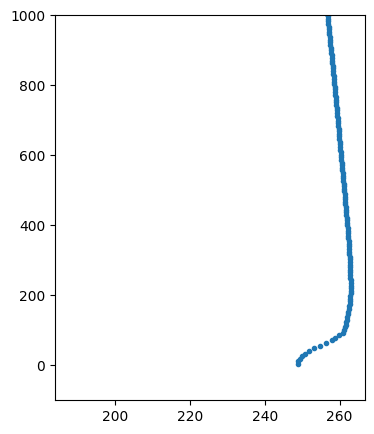

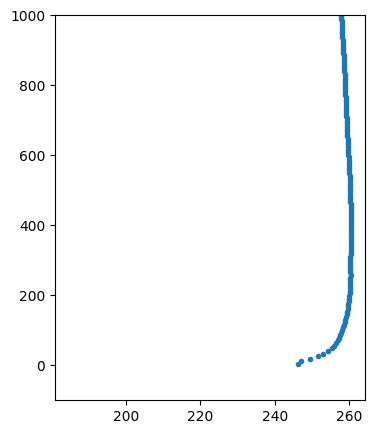

In [27]:
print(data_cube.met.ds)

fig, ax = plt.subplots(figsize=(4,5))
ax.plot(data_cube.met.ds.isel(time=0)['temperature'], data_cube.met.ds.height, '.')
ax.set_ylim(-100, 1000)

fig, ax = plt.subplots(figsize=(4,5))
ax.plot(data_cube.met.ds.isel(time=-1)['temperature'], data_cube.met.ds.height, '.')
ax.set_ylim(-100, 1000)

In [28]:
data_cube.calcMolecular()

time slices of cloud free  [array(['2023-06-18T00:17:30.000000', '2023-06-18T02:30:00.000000'],
      dtype='datetime64[us]'), array(['2023-06-18T08:20:00.000000', '2023-06-18T10:50:00.000000'],
      dtype='datetime64[us]'), array(['2023-06-18T22:05:00.000000', '2023-06-18T23:55:00.000000'],
      dtype='datetime64[us]')]
len mean_profiles 3
shape of the molecular scattering (3, 3000)
for the wavelengths  [355, 387, 407, 532, 607, 1058, 1064]


In [29]:
print(data_cube.mol_profiles.keys())


dict_keys(['mBsc_355', 'mExt_355', 'mBsc_387', 'mExt_387', 'mBsc_407', 'mExt_407', 'mBsc_532', 'mExt_532', 'mBsc_607', 'mExt_607', 'mBsc_1058', 'mExt_1058', 'mBsc_1064', 'mExt_1064', 'number_density'])


In [30]:
m_reference = np.load('20230618_0000_rayleigh_cal_testinterval_matlab.npz')

print(m_reference.files)
print(m_reference['cloud_free'])

m_py = data_cube.mol_profiles
print(m_py.keys())

['height', 'number_density', 'cloud_free', 'mBsc355', 'mExt355', 'mBsc387', 'mExt387', 'mBsc407', 'mExt407', 'mBsc532', 'mExt532', 'mBsc607', 'mExt607', 'mBsc1064', 'mExt1064']
[[  36  301]
 [1001 1301]
 [2651 2871]]
dict_keys(['mBsc_355', 'mExt_355', 'mBsc_387', 'mExt_387', 'mBsc_407', 'mExt_407', 'mBsc_532', 'mExt_532', 'mBsc_607', 'mExt_607', 'mBsc_1058', 'mExt_1058', 'mBsc_1064', 'mExt_1064', 'number_density'])


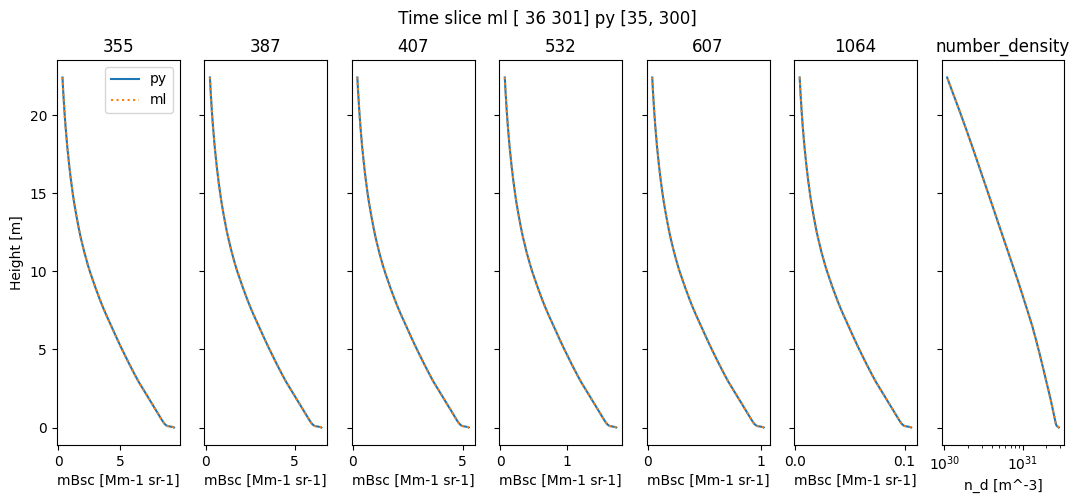

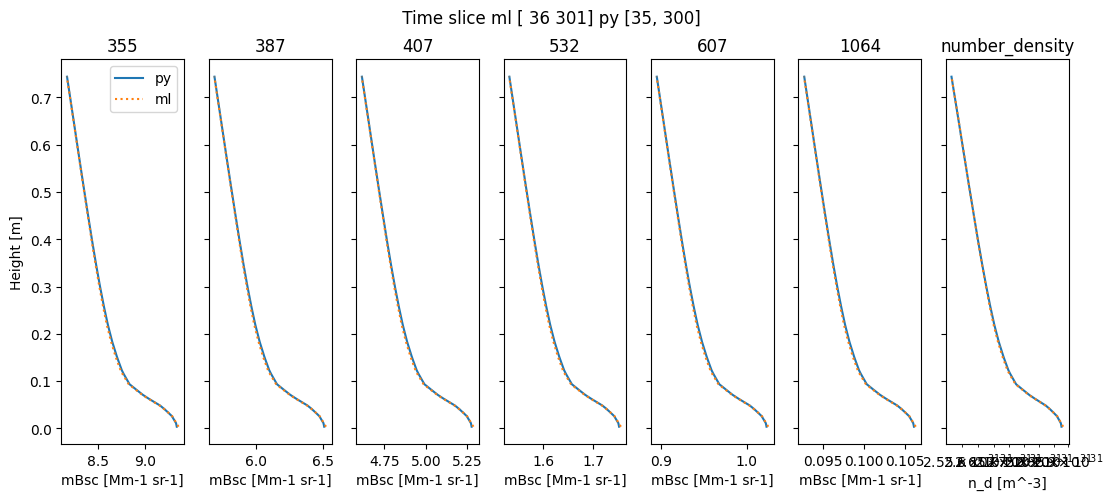

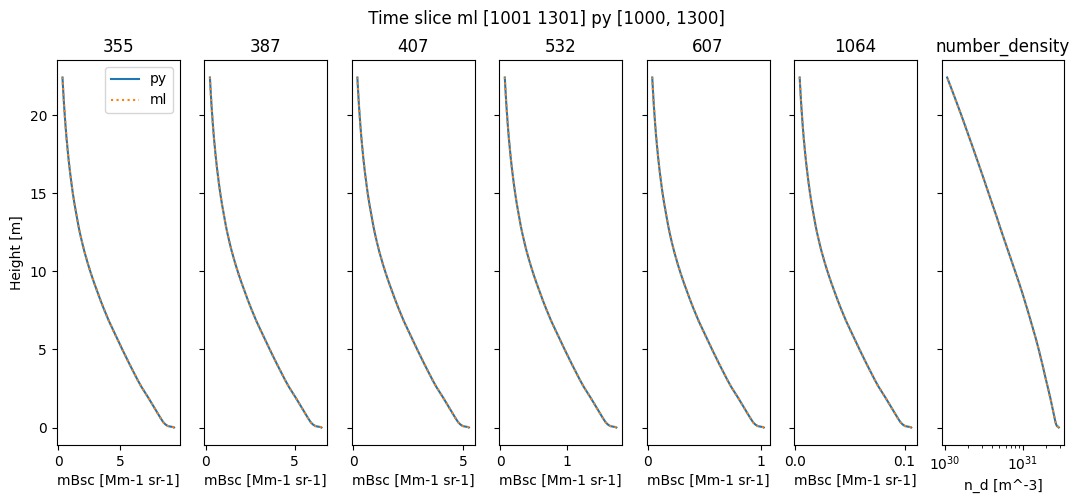

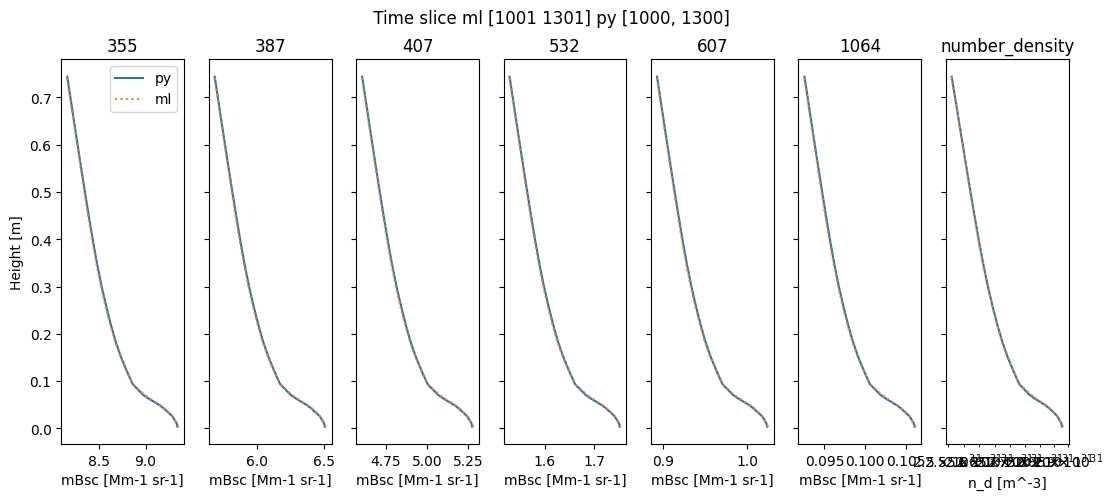

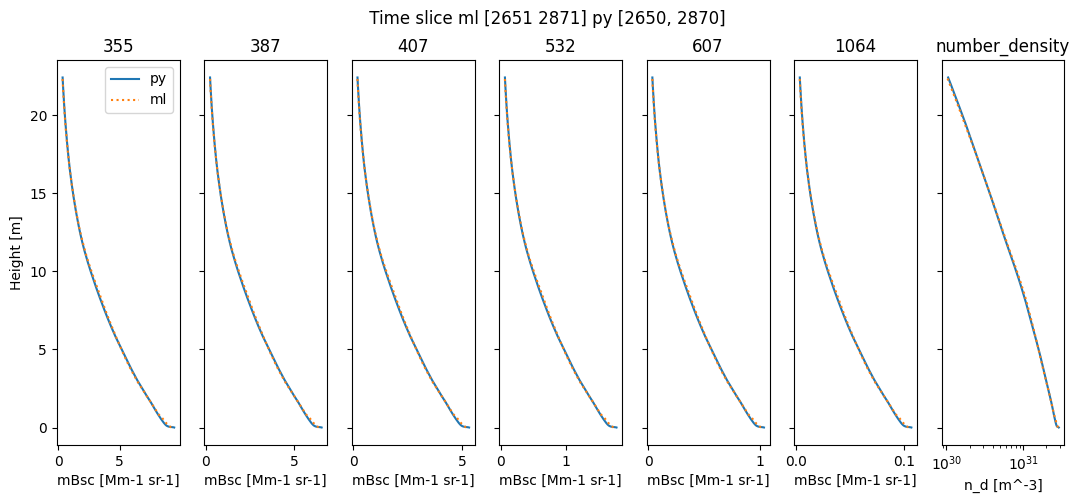

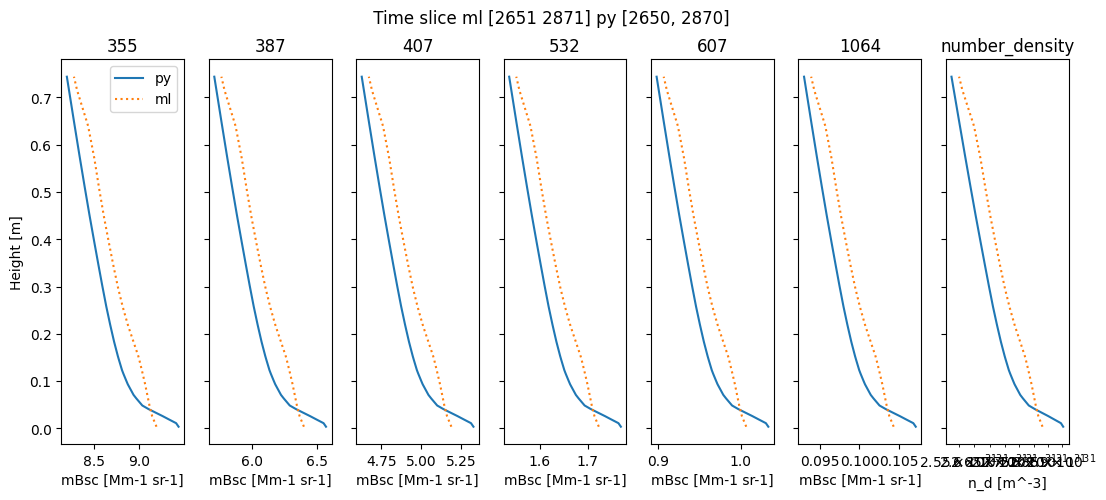

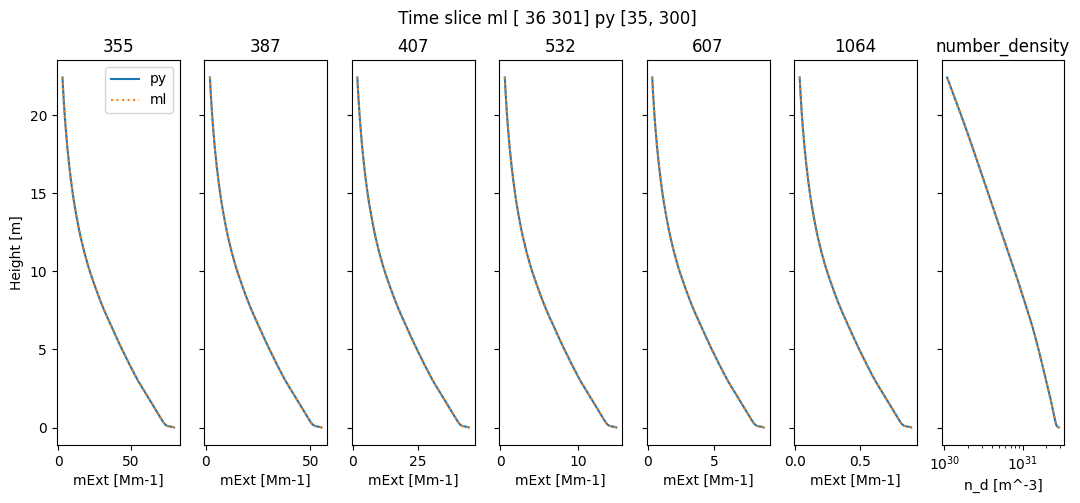

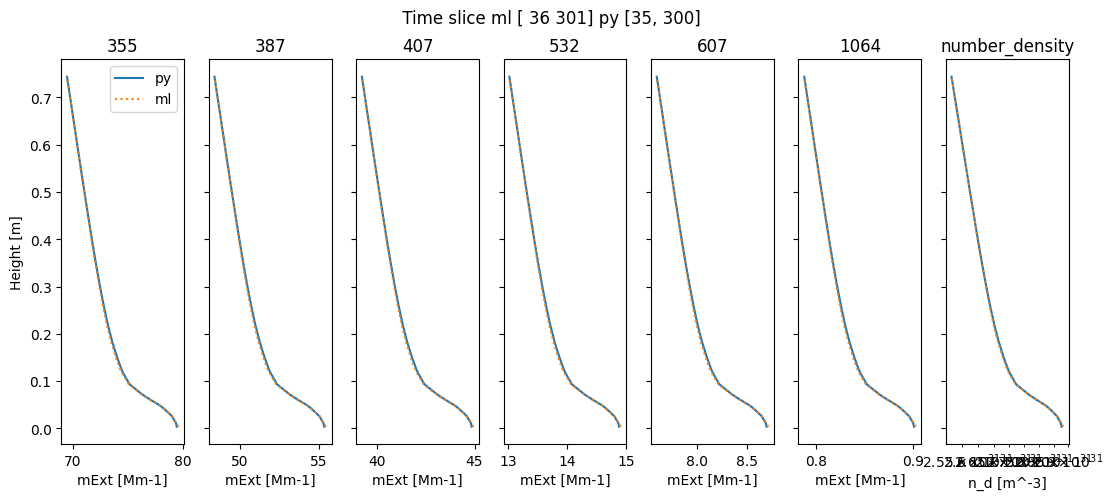

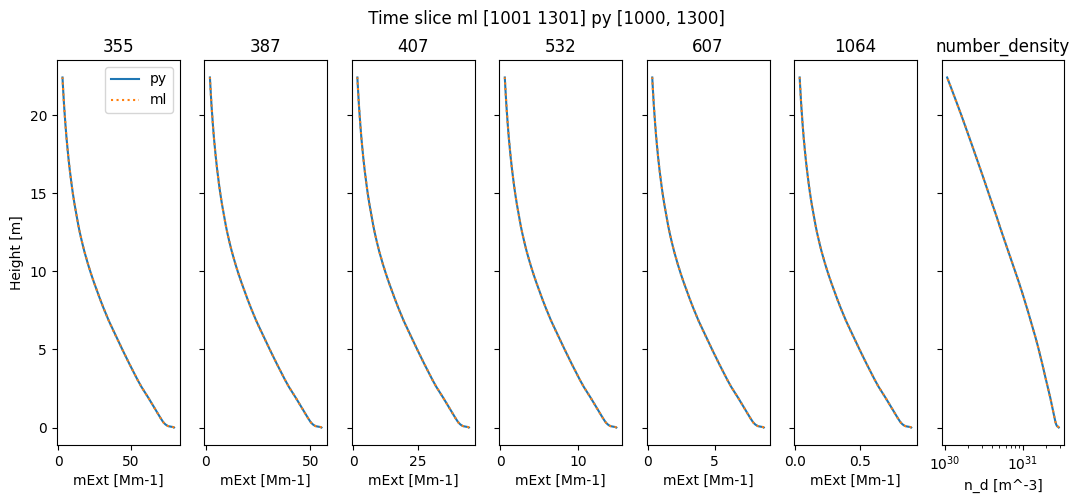

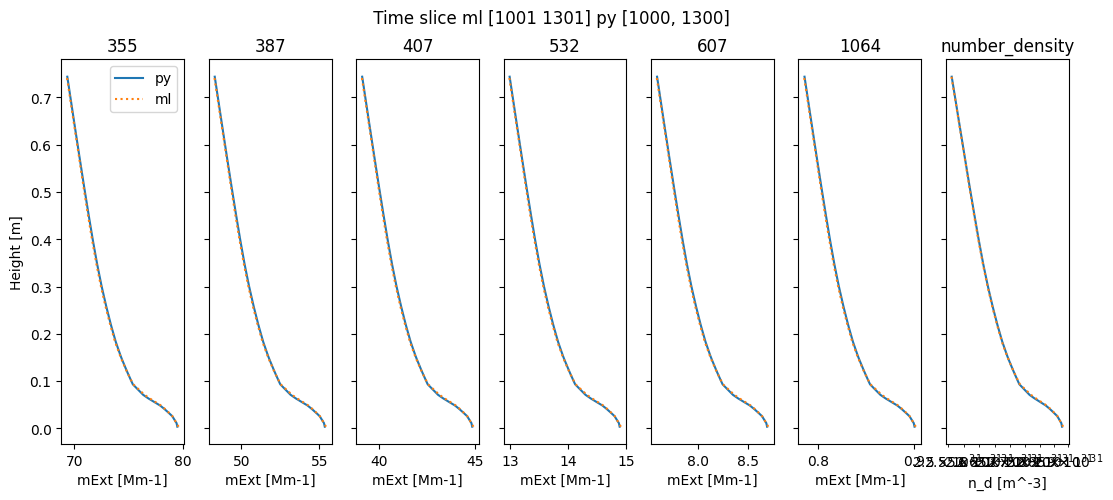

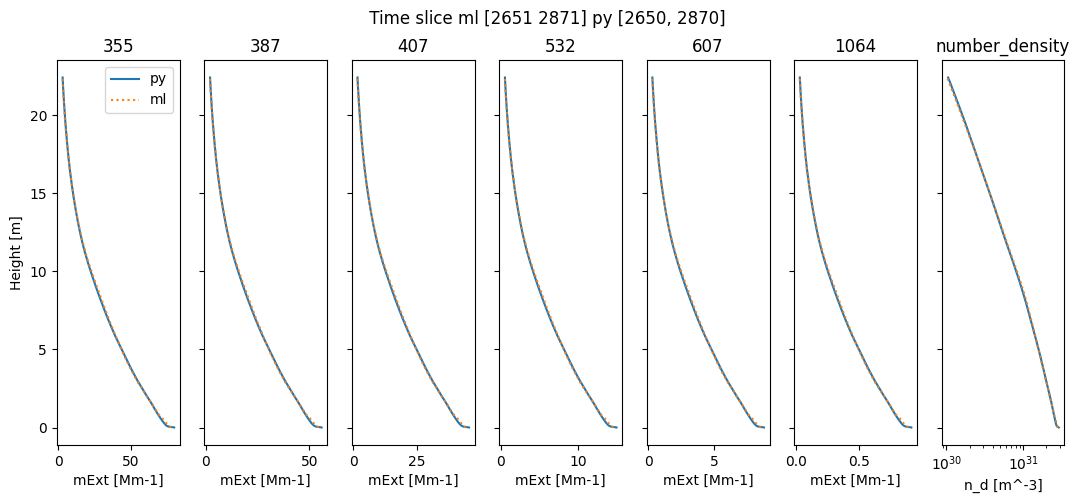

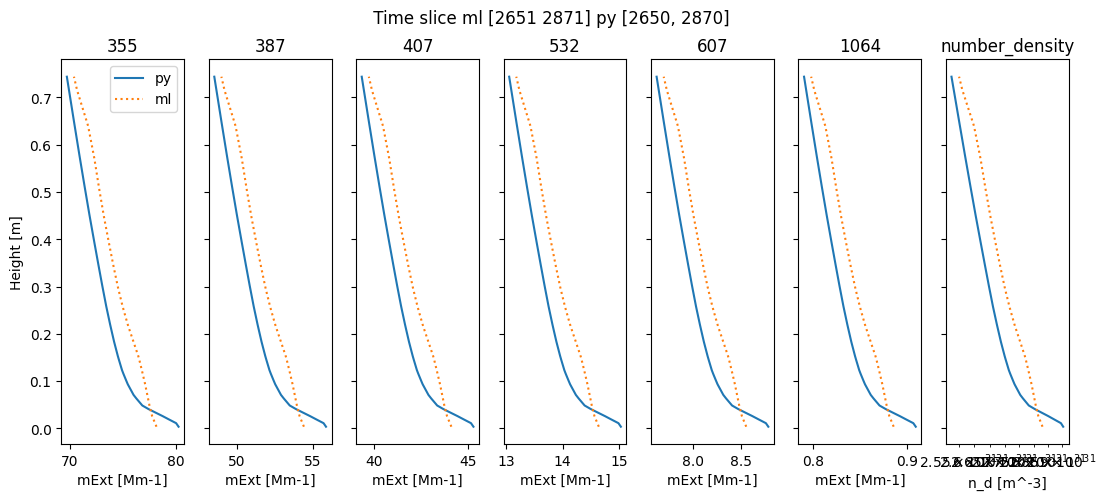

In [31]:
comparisons = [
    ['mBsc', 0, -1],
    ['mBsc', 0, 100],
    ['mBsc', 1, -1],
    ['mBsc', 1, 100],
    ['mBsc', 2, -1],
    ['mBsc', 2, 100],
    ['mExt', 0, -1],
    ['mExt', 0, 100],
    ['mExt', 1, -1],
    ['mExt', 1, 100],
    ['mExt', 2, -1],
    ['mExt', 2, 100],
]

for var, icld, imax in comparisons:
    # print(m_reference['height'])
    fig, ax = plt.subplots(1,7 ,figsize=(13,5), sharey=True)
    ax[0].plot(m_py[f'{var}_355'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-', label='py')
    ax[0].plot(m_reference[f'{var}355'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':', label='ml')
    ax[0].set_ylabel('Height [m]')
    ax[0].legend()
    ax[0].set_title('355')
    
    ax[1].plot(m_py[f'{var}_387'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[1].plot(m_reference[f'{var}387'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[1].set_title('387')
    
    ax[2].plot(m_py[f'{var}_407'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[2].plot(m_reference[f'{var}407'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[2].set_title('407')
    
    ax[3].plot(m_py[f'{var}_532'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[3].plot(m_reference[f'{var}532'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[3].set_title('532')
    
    ax[4].plot(m_py[f'{var}_607'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[4].plot(m_reference[f'{var}607'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[4].set_title('607')
    
    ax[5].plot(m_py[f'{var}_1064'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[5].plot(m_reference[f'{var}1064'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[5].set_title('1064')
    
    for i in range(0,6):
        if var == 'mBsc':
            ax[i].set_xlabel(f'{var} [Mm-1 sr-1]')
        elif var == 'mExt':
            ax[i].set_xlabel(f'{var} [Mm-1]')
    
    ax[6].plot(m_py['number_density'][icld,:imax]*1e6, data_cube.met.ds.height[:imax]/1000, '-')
    ax[6].plot(m_reference['number_density'][icld,:imax]*1e6, m_reference['height'][:imax]/1000, ':')
    ax[6].set_xlabel('n_d [m^-3]')
    ax[6].set_title('number_density')
    ax[6].set_xscale('log')
    
    # ax[0].set_ylim(0, 1000)
    fig.suptitle(f" Time slice ml {m_reference['cloud_free'][icld]} py {data_cube.clFreeGrps[icld]}")
    
    fig.savefig(f"{var}_icld_{icld}_hmax_{data_cube.met.ds.height[imax].values:.0f}.png")

    

In [32]:
m_py = data_cube.mol_profiles

m_py.keys()

dict_keys(['mBsc_355', 'mExt_355', 'mBsc_387', 'mExt_387', 'mBsc_407', 'mExt_407', 'mBsc_532', 'mExt_532', 'mBsc_607', 'mExt_607', 'mBsc_1058', 'mExt_1058', 'mBsc_1064', 'mExt_1064', 'number_density'])

dict_keys(['sig532', 'bg532', 'nShots532', 'pcr532', 'height', 'rcs532', 'scaRatio', 'mSig532'])
mSig [1.75138169e-06 1.74953757e-06 1.74496387e-06 1.74040557e-06
 1.73261765e-06 1.72460711e-06 1.71559099e-06 1.70345021e-06
 1.69146077e-06 1.68029974e-06 1.67098768e-06 1.66176328e-06
 1.65263773e-06 1.64820090e-06 1.64383312e-06 1.63948061e-06
 1.63565571e-06 1.63273751e-06 1.62982442e-06 1.62691644e-06]


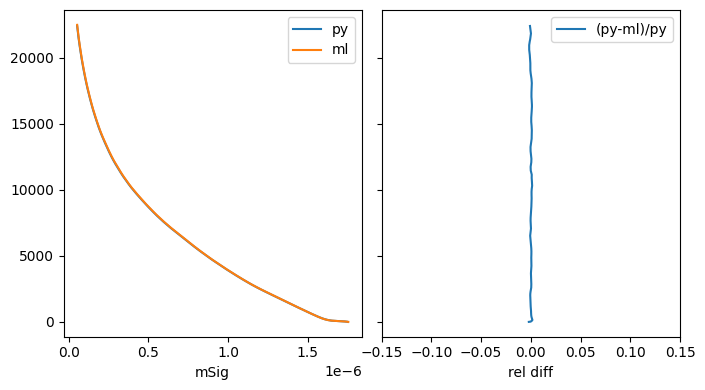

In [33]:
# rcs, mSig, scaRatio = data_cube.rayleighFit()

i = 0
height = data_cube.data_retrievals['range']
mSig = (
    data_cube.mol_profiles[f'mBsc_532'][i,:] * \
    np.exp(-2 * np.cumsum(data_cube.mol_profiles[f'mExt_532'][i,:] * np.concatenate(([height[0]], np.diff(height))))))



with open('20230618_0000_pcr_rcs_matlab.pickle', 'rb') as f:
    pcr_rcs_ml = pickle.load(f)
print(pcr_rcs_ml.keys())

# imax = 200
imax = -1

# im = 3000


fig, (ax, ax1) = plt.subplots(1,2,figsize=(7,4), sharey=True)
ax.plot(mSig[:imax], data_cube.data_retrievals['height'][:imax], label='py')
ax.plot(pcr_rcs_ml['mSig532'][:imax], pcr_rcs_ml['height'][:imax], label='ml')
ax.legend()
ax.set_xlabel('mSig')

reldiff = (mSig[:imax] - pcr_rcs_ml['mSig532'][:imax])/mSig[:imax]
ax1.plot(reldiff, data_cube.data_retrievals['height'][:imax], label='(py-ml)/py')
ax1.legend()
ax1.set_xlim(-0.15, 0.15); ax1.set_xlabel('rel diff')
fig.tight_layout()
# fig.savefig('mSig_rayleigh_fit.png')
print('mSig', mSig[:20])


# # rcs = np.nanmean(np.squeeze(
# #     data_cube.data_retrievals['RCS'][slice(*cldFree),:,data_cube.gf(532, 'total', 'FR')]), axis=0)


# fig, ax = plt.subplots(1 ,figsize=(6,4))

# ax.plot(np.squeeze(data_cube.data_retrievals['RCS'][35,:,data_cube.gf(532, 'total', 'FR')])[:imax], 
#         data_cube.data_retrievals['height'][:imax], color='grey', label='py single profile')
# ax.plot(rcs[:imax], data_cube.data_retrievals['height'][:imax], label='py averaged')
# ax.plot(pcr_rcs_ml['rcs532'][:imax], pcr_rcs_ml['height'][:imax], label='ml averaged')
# ax.legend()
# ax.set_xlabel('RCS 532')



# pcr_manual = np.mean(np.squeeze(data_cube.data_retrievals['PCR_cor'][35:300,:,data_cube.gf(532, 'total', 'FR')]), axis=0)


# fig, ax = plt.subplots(1 ,figsize=(6,4))
# ax.plot(pcr_manual[250:250+im], 
#         np.arange(6400)[:im], label='py single profile')
# ax.plot(pcr_rcs_ml['pcr532'][:im], np.arange(6400)[:im], ls=':', label='ml averaged')

# # note for continuing:
# # - pcr seems correct with execption of the 250 bins pretrigger
# #


# rcs_manual = pcr_manual[251:3251]*data_cube.data_retrievals['range']**2
# rcs_manual_0based = pcr_manual[250:3250]*data_cube.data_retrievals['range']**2

# fig, (ax, ax1) = plt.subplots(1,2,figsize=(7,4), sharey=True)
# # ax.plot(rcs_manual[:im], 
# #         data_cube.data_retrievals['height'][:im], color='dimgrey', lw=3, label='py manual')
# ax.plot(pcr_rcs_ml['rcs532'][:im], pcr_rcs_ml['height'][:im], '-', lw=3, color='tab:orange', label='ml averaged')
# ax.plot(rcs[:im], data_cube.data_retrievals['height'][:im], '--', lw=1, color='magenta', label='py wrong')
# ax.plot(rcs_manual_0based[:im], data_cube.data_retrievals['height'][:im], '--', lw=1, color='dodgerblue', label='py 0-based')
# ax.legend()
# ax.set_xlabel('RCS 532')
# ax.set_ylabel('Height')

# reldiff = (rcs - pcr_rcs_ml['rcs532'])/rcs
# ax1.axvline(0, lw=0.8, c='k')
# ax1.plot(reldiff[:im], data_cube.data_retrievals['height'][:im], label='(py-ml)/py')
# ax1.plot(smooth_signal(reldiff[:im], 30), data_cube.data_retrievals['height'])
# ax1.legend()
# ax1.set_xlim(-0.15, 0.15); ax1.set_xlabel('rel diff')
# fig.tight_layout()
# # fig.savefig('rcs_rayleigh_fit.png')


# fig, ax1 = plt.subplots(1,figsize=(3,5))
# ax1.axvline(0, lw=0.8, c='k')
# ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
# ax1.plot(smooth_signal(reldiff, 30), data_cube.data_retrievals['height'])
# ax1.legend()
# ax1.set_xlim(-0.1, 0.1); ax1.set_xlabel('rel diff')
# ax1.set_ylabel('Height')
# fig.tight_layout()
# # fig.savefig('rcs_reldiff_rayleigh_fit.png')

# fig, ax = plt.subplots(1 ,figsize=(6,4))
# ax.plot(scaRatio[:imax], data_cube.data_retrievals['height'][:imax], label='py')
# ax.plot(pcr_rcs_ml['scaRatio'][:imax], pcr_rcs_ml['height'][:imax], label='ml')
# ax.legend()
# ax.set_xlabel('scaRatio')

In [34]:
print(pcr_rcs_ml['height'][:10])
print(data_cube.data_retrievals['height'][:10])
print(data_cube.data_retrievals['range'][:10])

[ 3.76432439 11.26432439 18.76432439 26.26432439 33.76432439 41.26432439
 48.76432439 56.26432439 63.76432439 71.26432439]
[ 3.75       11.22146024 18.69292047 26.16438071 33.63584094 41.10730118
 48.57876141 56.05022165 63.52168189 70.99314212]
[ 3.75 11.25 18.75 26.25 33.75 41.25 48.75 56.25 63.75 71.25]


In [35]:
print(data_cube.polly_config_dict['flagUseManualRefH'])
print(data_cube.polly_config_dict[f'refH_FR_355'])
print(data_cube.polly_config_dict[f'refH_FR_532'])
print(data_cube.polly_config_dict[f'refH_FR_1064'])

data_cube.polly_config_dict['flagUseManualRefH'] = False
data_cube.polly_config_dict[f'refH_FR_355'] = [6000, 8000]
data_cube.polly_config_dict[f'refH_FR_532'] = [6000, 8000]
data_cube.polly_config_dict[f'refH_FR_1064'] = [6000, 8000]

False
[]
[]
[]


In [36]:
data_cube.rayleighFit()

2025-01-06 13:49:26,100 - WARNING - Potential for differences to matlab code du to numerical issues (subtraction of two small values)
2025-01-06 13:49:26,101 - WARNING - rayleighfit seems to use range in matlab, but the met data should be in height >> RECHECK!
2025-01-06 13:49:26,102 - WARNING - at 10km height this is a difference of about 4 indices


Start Rayleigh Fit
0 [35, 300]
refH for 532
height [  3.75  11.25  18.75  26.25  33.75  41.25  48.75  56.25  63.75  71.25
  78.75  86.25  93.75 101.25 108.75 116.25 123.75 131.25 138.75 146.25
 153.75 161.25 168.75 176.25 183.75 191.25 198.75 206.25 213.75 221.25] epsilon 0.2 height [1000] 10000 maxHThick 1500 window_size 60
hBaseIndx 133 1001.25
hTopIndx 1333 10001.25
DPInd [ 132  332  532  674  874 1074 1274 1332]
0 132 333
Region 0: 993.75 - 2501.25 fails in near and far-Range cross test.
1 332 533
Region 1: 2493.75 - 4001.25 fails in near and far-Range cross test.
2 532 675
Region 2: 3993.75 - 5066.25 fails in near and far-Range cross test.
3 674 875
white noise criterion  674 875
white noise chi2fit input 5.80875 6.110436684172814e-23 1.974405277672919e-08
white noise chi2fit  1.628851469635786e-08 -2.8795840608025443e-09
all tests succeeded
4 874 1075
white noise criterion  874 1075
white noise chi2fit input 7.308750000000001 5.530998722742632e-23 2.218531356418841e-08
white nois

[{'532_total_FR': {'DPInd': array([ 132,  332,  532,  674,  874, 1074, 1274, 1332]),
   'refHInd': (674, 874)},
  '355_total_FR': {'DPInd': array([ 172,  372,  572,  772,  972, 1172, 1332]),
   'refHInd': (772, 972)},
  '1064_total_FR': {'DPInd': array([ 132,  332,  333,  439,  497,  550,  655,  708,  908, 1038, 1238,
          1332]),
   'refHInd': (708, 908)}},
 {'532_total_FR': {'DPInd': array([ 132,  316,  516,  548,  748,  948, 1148, 1332]),
   'refHInd': (748, 948)},
  '355_total_FR': {'DPInd': array([ 172,  372,  572,  772,  972, 1172, 1332]),
   'refHInd': (972, 1172)},
  '1064_total_FR': {'DPInd': array([ 132,  216,  308,  357,  421,  583,  783,  983, 1121, 1321, 1332]),
   'refHInd': (583, 783)}},
 {'532_total_FR': {'DPInd': array([ 132,  332,  532,  732,  932, 1132, 1332]),
   'refHInd': (732, 932)},
  '355_total_FR': {'DPInd': array([ 172,  372,  572,  772,  972, 1172, 1332]),
   'refHInd': (772, 972)},
  '1064_total_FR': {'DPInd': array([ 132,  332,  532,  732,  783,  983,

In [37]:
# overwrite manual reference heights for the test case

data_cube.refH = [
    {'532_total_FR': {'DPInd': [], 'refHInd': [675, 875,]},
     '355_total_FR': {'DPInd': [], 'refHInd': [975, 1175]},
     '1064_total_FR': {'DPInd': [], 'refHInd': [721, 1121]},},
    # {'532_total_FR': {'DPInd': [], 'refHInd': [587, 787]},
    {'532_total_FR': {'DPInd': [], 'refHInd': [962, 1162]},
     '355_total_FR': {'DPInd': [], 'refHInd': [775, 975]},
     '1064_total_FR': {'DPInd': [], 'refHInd': [583, 783]},},
    {'532_total_FR': {'DPInd': [], 'refHInd': [962, 1162]},
     '355_total_FR': {'DPInd': [], 'refHInd': [975, 1174]},
     '1064_total_FR': {'DPInd': [], 'refHInd': [583, 783]},},
]

In [38]:
# Manually add the defaults
data_cube.polly_config_dict["molDepol532"] = 0.0041
data_cube.polly_config_dict["molDepolStd532"] = 0.001
data_cube.polly_config_dict["molDepol355"] = 0.0106
data_cube.polly_config_dict["molDepolStd355"] = 0.0015

data_cube.polly_config_dict['flagMolDepolCali'] = False
pol_cali = data_cube.polarizationCaliMol()

2025-01-06 13:49:31,319 - WARNING - not checked against the matlab code


In [39]:
if 'pol_cali_mol' in data_cube.__dict__.keys():
    data_cube.pol_cali_mol

In [40]:
data_cube.pol_cali

{355: {'eta': [19.368045522896264, 19.383801254217833, 19.584845925714056],
  'eta_std': [0.3166358591227246, 0.3189075057891532, 0.34237386445508083],
  'time_start': [1687039590, 1687082790, 1687104390],
  'time_end': [1687040100, 1687083300, 1687104900],
  'status': 1,
  'eta_best': 19.368045522896264},
 532: {'eta': [28.495323267051297, 28.629593457507827, 28.788399775483036],
  'eta_std': [0.4043573463320397, 0.38729488535017403, 0.3417234358677146],
  'time_start': [1687039590, 1687082790, 1687104390],
  'time_end': [1687040100, 1687083300, 1687104900],
  'status': 1,
  'eta_best': 28.788399775483036}}

In [41]:
data_cube.transCor()

2025-01-06 13:49:37,935 - WARNING - NO transmission correction
2025-01-06 13:49:40,298 - INFO - and even a 355 channel


[ True False False False False False False False False False False False
 False] [0]
G [1.] [1.]
H [0.18343195] [-0.99600798]
polCaliEta 19.368045522896264


2025-01-06 13:49:43,211 - INFO - and even a 532 channel


[False False False False  True False False False False False False False
 False] [4]
G [1.] [1.]
H [-0.0430622] [-0.99600798]
polCaliEta 28.788399775483036
[False False False False False False False  True False False False False
 False] [7]


In [42]:
data_cube.data_retrievals['sigTCor'].shape

(2880, 3000, 13)

dict_keys(['el532', 'bgEl532', 'height'])


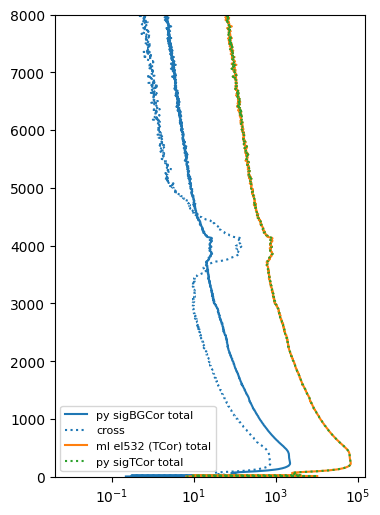

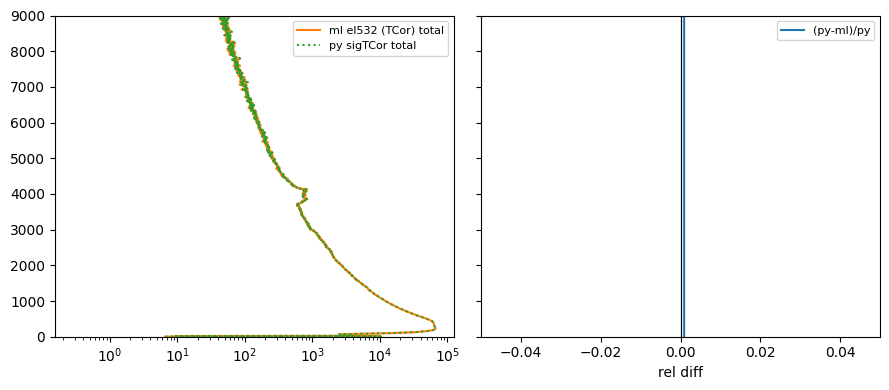

In [43]:
mean_532_total = np.mean(data_cube.data_retrievals['sigBGCor'][39:139,:,4], axis=0)
mean_532_cross = np.mean(data_cube.data_retrievals['sigBGCor'][39:139,:,5], axis=0)
mean_TCor_532_total = np.mean(data_cube.data_retrievals['sigTCor'][39:139,:,4], axis=0)

with open('20230618_0000_sigTCor_matlab.pickle', 'rb') as f:
    sigTCor_ml = pickle.load(f)
print(sigTCor_ml.keys())

mean_TCor_532_total_ml = np.mean(sigTCor_ml['el532'][:, 39:139], axis=1)

fig, ax = plt.subplots(1, figsize=(4, 6))
ax.plot(mean_532_total, np.array(data_cube.data_retrievals['height']), color='C0', label='py sigBGCor total')
ax.plot(mean_532_cross, np.array(data_cube.data_retrievals['height']), color='C0', ls=':', label='cross')

ax.plot(mean_TCor_532_total_ml, np.array(sigTCor_ml['height']), color='C1', label='ml el532 (TCor) total')
# ax.plot(comp_ml['sig532c_40_140'], np.array(data_cube.data_retrievals['height']), color='C1', ls=':', label='cross')

ax.plot(mean_TCor_532_total, np.array(data_cube.data_retrievals['height']), color='C2', ls=':', label='py sigTCor total')

ax.set_ylim(0, 8000)
ax.set_xscale('log')
ax.legend(fontsize=8)



fig, (ax, ax1) = plt.subplots(1,2, figsize=(9,4), sharey=True)
ax.plot(mean_TCor_532_total_ml, np.array(sigTCor_ml['height']), color='C1', label='ml el532 (TCor) total')
ax.plot(mean_TCor_532_total, np.array(data_cube.data_retrievals['height']), color='C2', ls=':', label='py sigTCor total')
ax.set_ylim(0, 9000)
ax.set_xscale('log')
ax.legend(fontsize=8)

reldiff = (mean_TCor_532_total - mean_TCor_532_total_ml)/mean_TCor_532_total
ax1.axvline(0, lw=0.9, color='k')
ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
ax1.legend(fontsize=8)
ax1.set_xlim(-0.05, 0.05); ax1.set_xlabel('rel diff')
fig.tight_layout()
# # fig.savefig('mSig_rayleigh_fit.png')
# print('mSig', mSig[:20])



In [44]:
data_cube.retrievalKlett()

2025-01-06 13:49:56,326 - WARNING - rayleighfit seems to use range in matlab, but the met data should be in height >> RECHECK!
2025-01-06 13:49:56,327 - WARNING - at 10km height this is a difference of about 4 indices


Starting Klett retrieval
cldFree  0 [35, 300]
cldFree mod (35, 301)
532, total, FR
(266, 3000, 1)
refHInd [675, 875] refH [5066.25 6566.25]
LR  50 [5066.25 6566.25] refBeta 1e-08 smoothWin_klett 21
indRefH [675, 875] 775
(3000,)
RCS[indRefMid]  1577799.1800821156
aerBR[indRefMid]  0.011372177675492395
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd'])
355, total, FR
(266, 3000, 1)
refHInd [975, 1175] refH [7316.25 8816.25]
LR  50 [7316.25 8816.25] refBeta 2e-08 smoothWin_klett 21
indRefH [975, 1175] 1075
(3000,)
RCS[indRefMid]  1151577.3645263712
aerBR[indRefMid]  0.005810713039422842
dict_keys(['aerBsc', 'aerBscStd', 'aerBR', 'aerBRStd', 'RCS', 'signal', 'molBsc', 'aerExt', 'aerExtStd'])
1064, total, FR
(266, 3000, 1)
refHInd [721, 1121] refH [5411.25 8411.25]
LR  50 [5411.25 8411.25] refBeta 2e-09 smoothWin_klett 21
indRefH [721, 1121] 921
(3000,)
RCS[indRefMid]  77138.30224481478
aerBR[indRefMid]  0.043370839212042274
dict_keys(

In [45]:
print(data_cube.data_retrievals.keys())
print(len(data_cube.data_retrievals['klett']))
print(data_cube.data_retrievals['klett'][0].keys())

dict_keys(['channel', 'PCR_cor', 'PCR_slice', 'preproSignal', 'BG', 'sigBGCor', 'height', 'range', 'alt', 'time', 'time64', 'SNR', 'lowSNRMask', 'depol_cal_ang_p_time_start', 'depol_cal_ang_p_time_end', 'depol_cal_ang_n_time_start', 'depol_cal_ang_n_time_end', 'depCalMask', 'RCS', 'sigTCor', 'BGTCor', 'klett'])
3
dict_keys(['532_total_FR', '355_total_FR', '1064_total_FR'])


dict_keys(['aerBsc355_klett', 'aerBsc532_klett', 'aerBsc1064_klett', 'aerBsc532_klett_manual', 'RCS532_manual', 'RCS1064_manual', 'signal_manual', 'molBsc_manual', 'mBsc355', 'mBsc532', 'mBsc1064', 'aerBR_manual', 'aerExt532_klett', 'pressure', 'temperature', 'height'])
[975, 1175] [7288.4237298  8782.71577693]
[775, 975] [5794.13168266 7288.4237298 ]
[975, 1174] [7288.4237298 8775.2443167]
[675, 875] [5046.98565909 6541.27770623]
[962, 1162] [7191.29474673 8685.58679387]
[962, 1162] [7191.29474673 8685.58679387]
[721, 1121] [5390.67282993 8379.25692421]
[583, 783] [4359.61131741 5853.90336454]


/tmp/ipykernel_209746/1648960077.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)


[583, 783] [4359.61131741 5853.90336454]


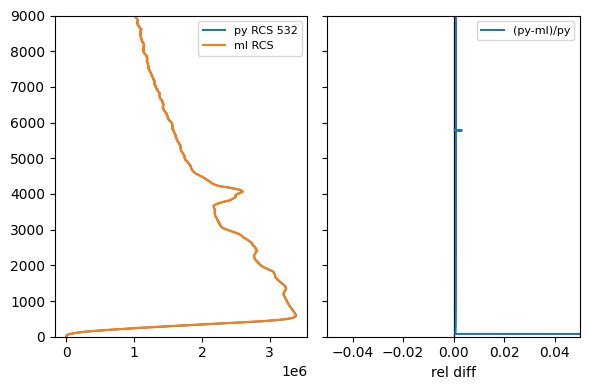

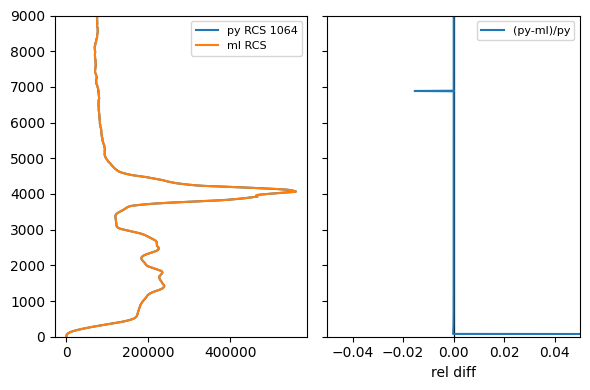

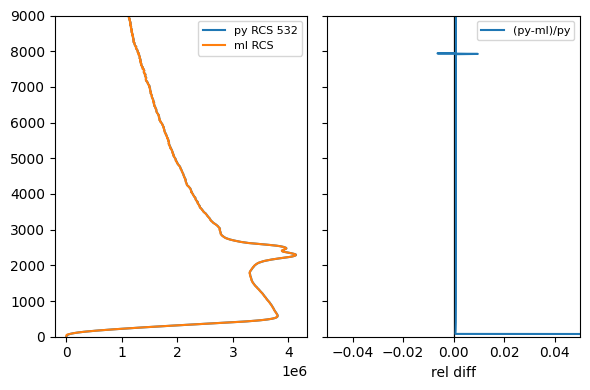

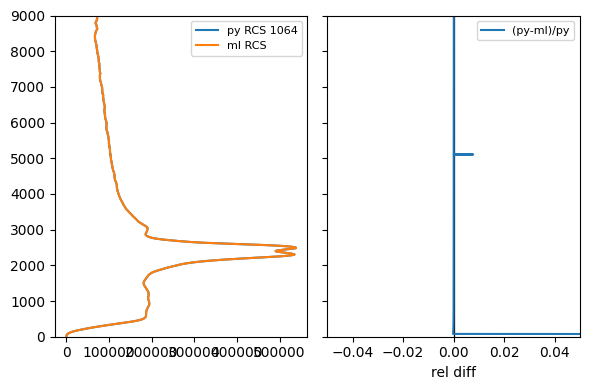

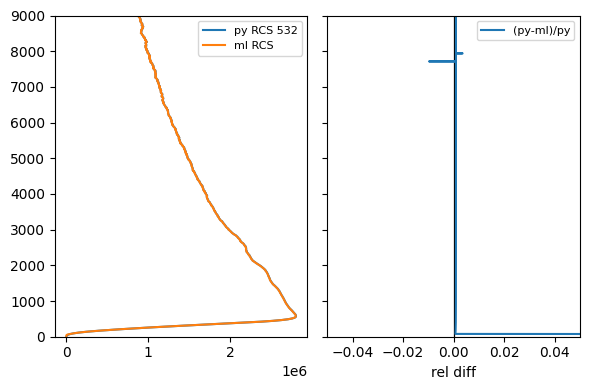

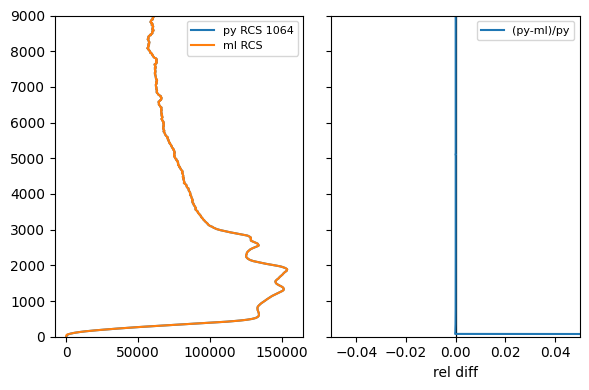

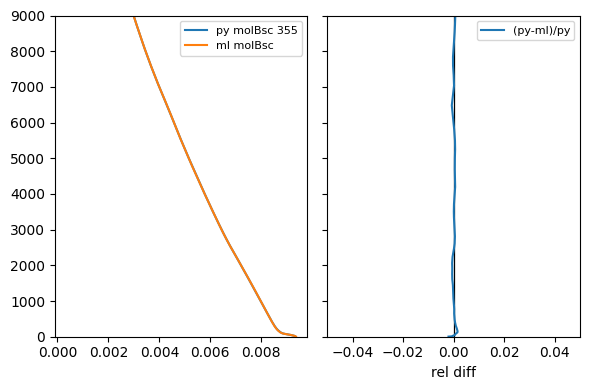

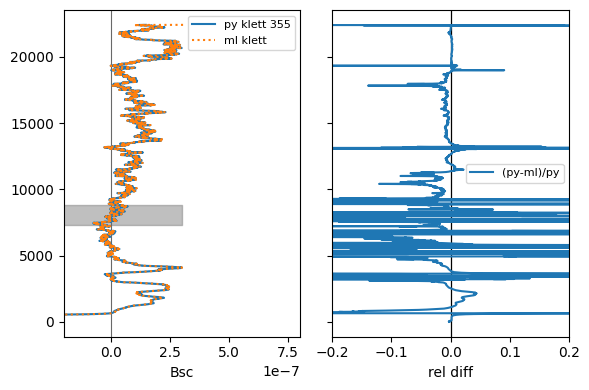

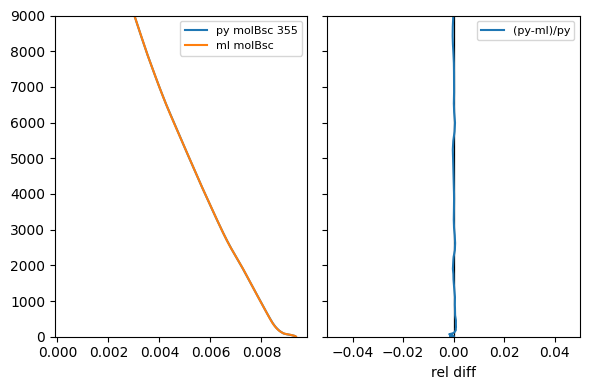

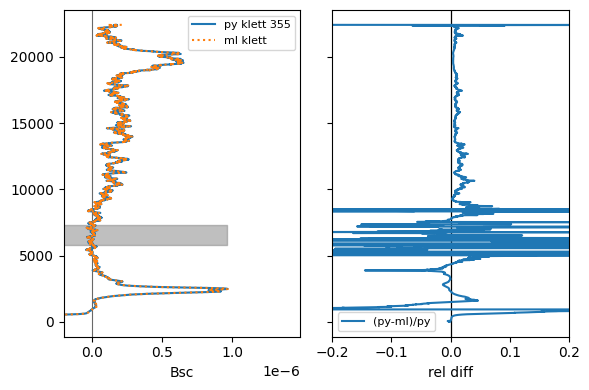

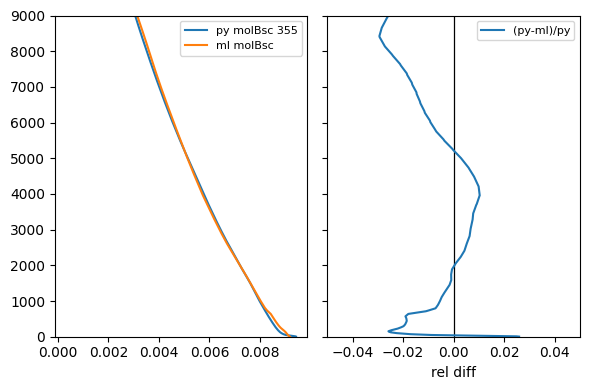

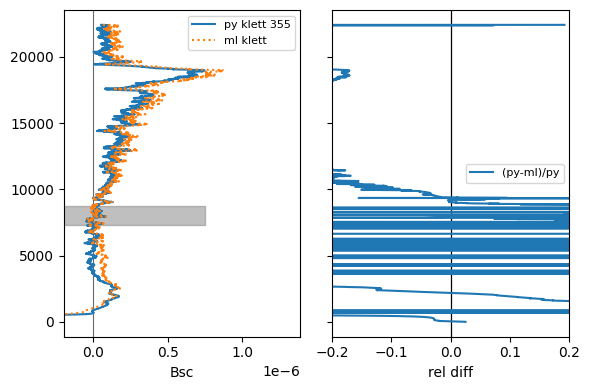

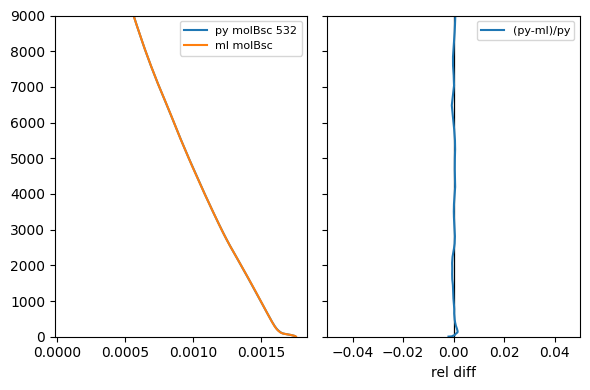

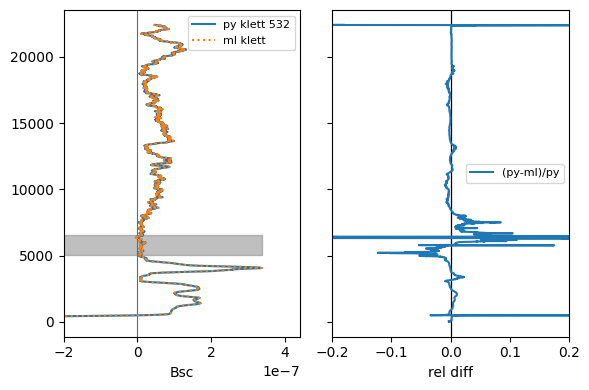

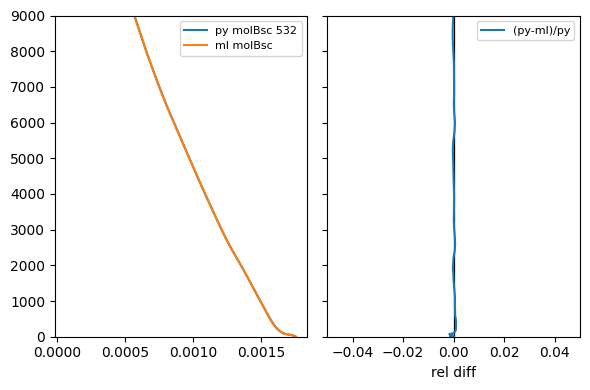

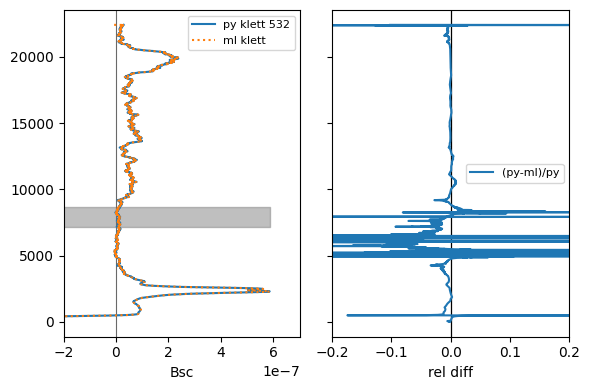

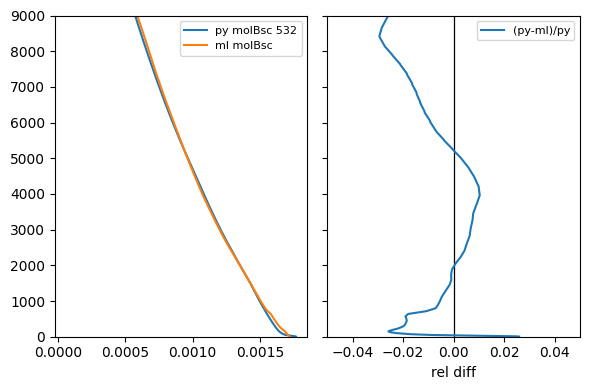

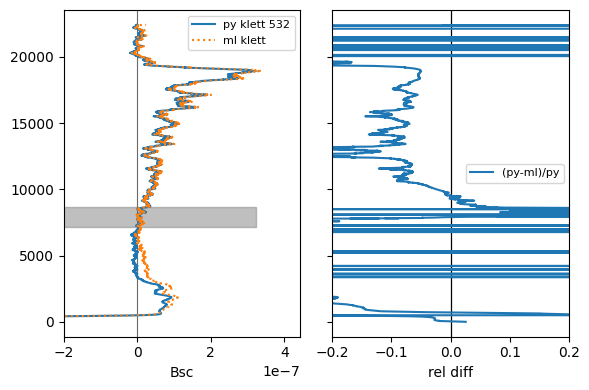

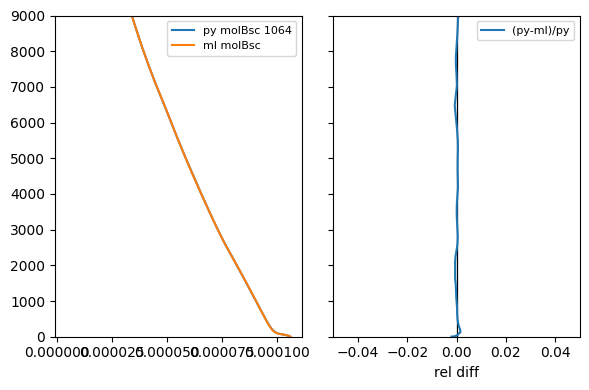

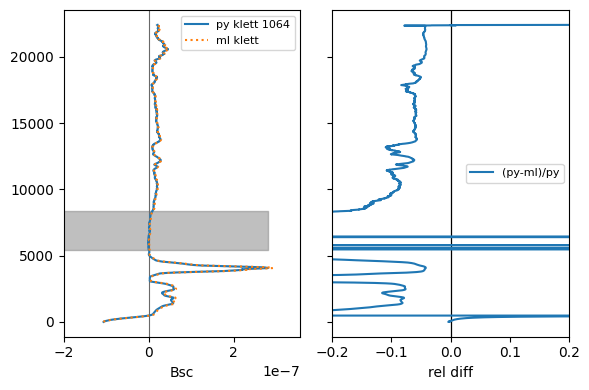

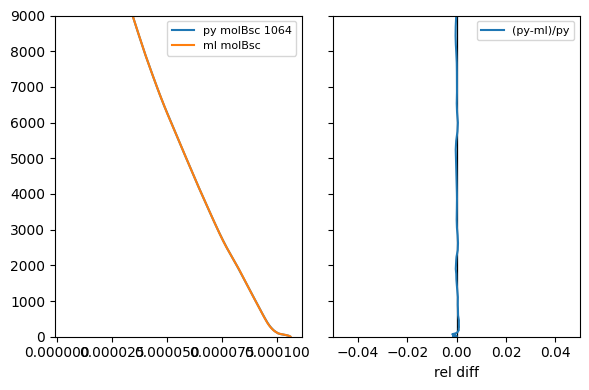

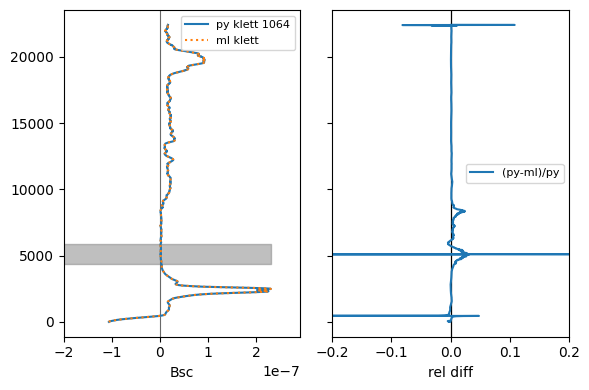

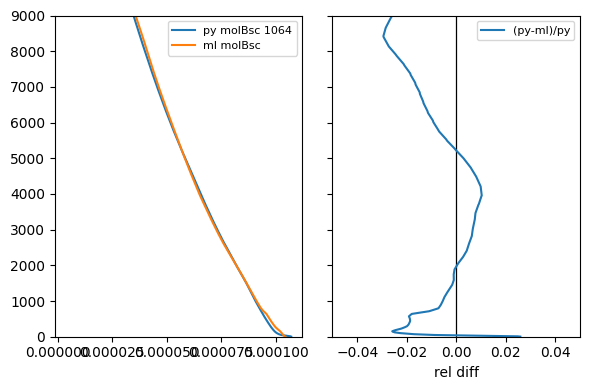

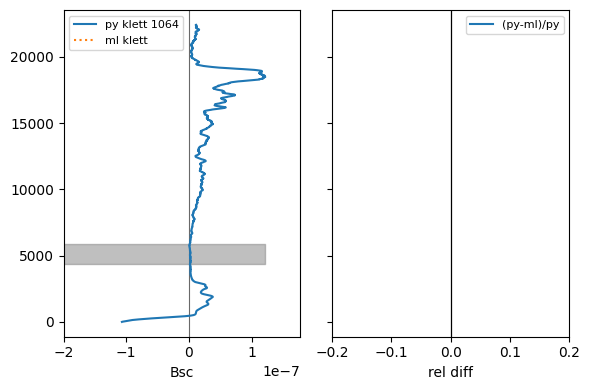

In [46]:
# aerBsc

with open('20230618_0000_beta_klett_matlab.pickle', 'rb') as f:
    beta_klett_ml = pickle.load(f)
print(beta_klett_ml.keys())

# fig, ax = plt.subplots(1, figsize=(4, 6))
# ax.plot(RCS, np.array(data_cube.data_retrievals['height']), color='C0', label='py RCS 532')

# ax.plot(np.array(beta_klett_ml['RCS_manual']), np.array(beta_klett_ml['height']), color='C1', label='ml RCS')

# ax.set_ylim(0, 10000)
# # ax.set_xscale('log')
# ax.legend(fontsize=8)
# # ax.set_xlabel('Bsc')
# # ax.set_xlim(left=-0.5e-6)

# fig, ax = plt.subplots(1, figsize=(4, 6))

# ax.plot(aerBsc, np.array(data_cube.data_retrievals['height']), color='C0', label='py klett 532')

# ax.plot(np.array(beta_klett_ml['aerBsc532_klett'])[0,:], np.array(beta_klett_ml['height']), color='C1', label='ml klett')
# ax.plot(np.array(beta_klett_ml['aerBsc532_klett_manual']), np.array(beta_klett_ml['height']), color='red', ls=':', label='ml klett man')

# # ax.set_ylim(0, 10000)
# # ax.set_xscale('log')
# ax.legend(fontsize=8)
# ax.set_xlabel('Bsc')
# ax.set_xlim(left=-0.5e-6)

for i in range(len(data_cube.data_retrievals['klett'])):

    if 'RCS' in data_cube.data_retrievals['klett'][i]['532_total_FR'].keys():
        RCS_py = data_cube.data_retrievals['klett'][i]['532_total_FR']['RCS']
        RCS_ml = np.array(beta_klett_ml['RCS532_manual'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.plot(RCS_py, np.array(data_cube.data_retrievals['height']), color='C0', label='py RCS 532')
        ax.plot(RCS_ml, np.array(beta_klett_ml['height']), color='C1', label='ml RCS')
        ax.set_ylim(0, 9000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        # ax.set_xlabel('Bsc')
        # ax.set_xlim(left=-0.5e-6)
        
        reldiff = (RCS_py - RCS_ml)/RCS_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        ax1.set_xlim(-0.05, 0.05); ax1.set_xlabel('rel diff')
        fig.tight_layout()
        # # fig.savefig('mSig_rayleigh_fit.png')
        # print('mSig', mSig[:20])

    if 'RCS' in data_cube.data_retrievals['klett'][i]['1064_total_FR'].keys():
        RCS_py = data_cube.data_retrievals['klett'][i]['1064_total_FR']['RCS']
        RCS_ml = np.array(beta_klett_ml['RCS1064_manual'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.plot(RCS_py, np.array(data_cube.data_retrievals['height']), color='C0', label='py RCS 1064')
        ax.plot(RCS_ml, np.array(beta_klett_ml['height']), color='C1', label='ml RCS')
        ax.set_ylim(0, 9000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        # ax.set_xlabel('Bsc')
        # ax.set_xlim(left=-0.5e-6)
        
        reldiff = (RCS_py - RCS_ml)/RCS_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        ax1.set_xlim(-0.05, 0.05); ax1.set_xlabel('rel diff')
        fig.tight_layout()
        # # fig.savefig('mSig_rayleigh_fit.png')
        # print('mSig', mSig[:20])

for wv in [355,532,1064]:
    for i in range(len(data_cube.data_retrievals['klett'])):

        refHInd = data_cube.refH[i][f"{wv}_total_FR"]['refHInd']
        refH = np.array(data_cube.data_retrievals['height'])[np.array(refHInd)]
        print(refHInd, refH)
        
        if 'molBsc' in data_cube.data_retrievals['klett'][i][f'{wv}_total_FR'].keys():
            molBsc_py = data_cube.data_retrievals['klett'][i][f'{wv}_total_FR']['molBsc']
            molBsc_ml = np.array(beta_klett_ml[f'mBsc{wv}'])[i,:]*1e3
            fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
            ax.plot(molBsc_py, np.array(data_cube.data_retrievals['height']), color='C0', label=f'py molBsc {wv}')
            ax.plot(molBsc_ml, np.array(beta_klett_ml['height']), color='C1', label='ml molBsc')
            ax.set_ylim(0, 9000)
            # ax.set_xscale('log')
            ax.legend(fontsize=8)
            # ax.set_xlabel('Bsc')
            # ax.set_xlim(left=-0.5e-6)
            
            reldiff = (molBsc_py - molBsc_ml)/molBsc_py
            ax1.axvline(0, lw=0.9, color='k')
            ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
            ax1.legend(fontsize=8)
            ax1.set_xlim(-0.05, 0.05); ax1.set_xlabel('rel diff')
            fig.tight_layout()
            # # fig.savefig('mSig_rayleigh_fit.png')
            # print('mSig', mSig[:20])
    
        beta_py = data_cube.data_retrievals['klett'][i][f'{wv}_total_FR']['aerBsc']
        beta_ml = np.array(beta_klett_ml[f'aerBsc{wv}_klett'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        ax.fill_between([-1e-6, np.max(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
                        color='grey', alpha=0.5)
        ax.plot(beta_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py klett {wv}')
        ax.plot(beta_ml, np.array(beta_klett_ml['height']), 
                color='C1', ls=':', label='ml klett')
        
        # ax.set_ylim(0, 10000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel('Bsc')
        ax.set_xlim(left=-0.2e-6)
    
        reldiff = (beta_py - beta_ml)/beta_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.2, 0.2); ax1.set_xlabel('rel diff')
        fig.tight_layout()
        # # # fig.savefig('mSig_rayleigh_fit.png')



candidates  ['/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230616_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230617_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230618_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230619_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230620_neumayer_ecmwf.nc']
regex  re.compile('.*/2023/20230618.*.nc')
filename  ['/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230618_neumayer_ecmwf.nc']
time slices of cloud free  [array(['2023-06-18T00:17:30.000000', '2023-06-18T02:30:00.000000'],
      dtype='datetime64[us]'), array(['2023-06-18T08:20:00.000000', '2023-06-18T10:50:00.000000'],
      dtype='datetime64[us]'), array(['2023-06-18T22:05:00.000000', '2023-06-18T23:55:00.000000'],
      dtype='datetime64[us]')]


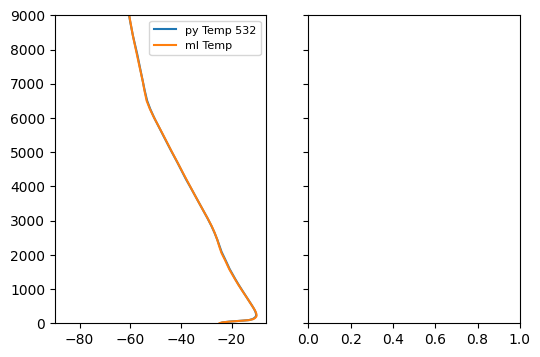

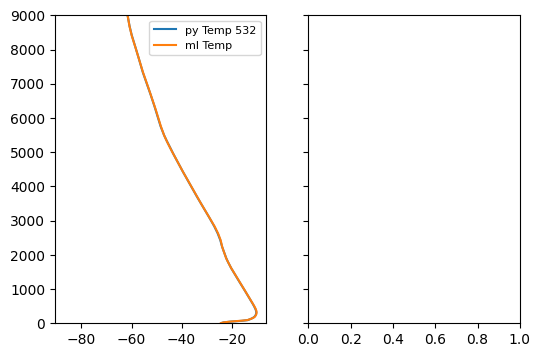

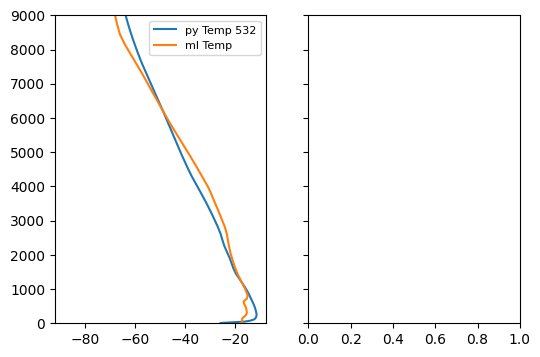

In [47]:
data_cube.loadMeteo()
time_slices = [data_cube.data_retrievals['time64'][grp] for grp in data_cube.clFreeGrps]
print('time slices of cloud free ', time_slices)
mean_profiles = data_cube.met.get_mean_profiles(time_slices) 

for i in range(len(data_cube.data_retrievals['klett'])):

    t_py = mean_profiles[i].temperature.values - 273.15
    t_ml = np.array(beta_klett_ml['temperature'])[i,:] 
    fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
    ax.plot(t_py, np.array(data_cube.data_retrievals['height']), color='C0', label='py Temp 532')
    ax.plot(t_ml, np.array(beta_klett_ml['height']), color='C1', label='ml Temp')
    ax.set_ylim(0, 9000)
    # ax.set_xscale('log')
    ax.legend(fontsize=8)
    # ax.set_xlabel('Bsc')
    # ax.set_xlim(left=-0.5e-6)
    
    # reldiff = (RCS_py - RCS_ml)/RCS_py
    # ax1.axvline(0, lw=0.9, color='k')
    # ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
    # ax1.legend(fontsize=8)
    # ax1.set_xlim(-0.05, 0.05); ax1.set_xlabel('rel diff')
    # fig.tight_layout()
    # # fig.savefig('mSig_rayleigh_fit.png')
    # print('mSig', mSig[:20])

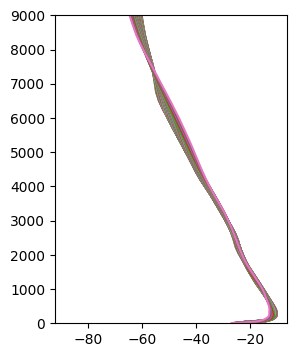

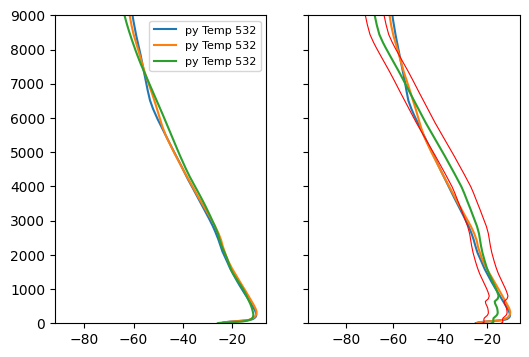

In [48]:
# for t in data_cube.met.ds.time:
#     print(t)

#     d = data_cube.met.ds.sel(time=t)
#     print(d)
#     fig, ax = plt.subplots(1, figsize=(3,4), sharey=True)
#     ax.plot(d.temperature-273.15, d.height, color='C0', label='py Temp 532')
#     ax.plot(t_ml, np.array(beta_klett_ml['height']), color='C1', label='ml Temp')
#     ax.set_ylim(0, 9000)
#     ax.set_title(t.values)

fig, ax = plt.subplots(1, figsize=(3,4), sharey=True)
for t in data_cube.met.ds.time:

    d = data_cube.met.ds.sel(time=t)
    ax.plot(d.temperature-273.15, d.height)
    ax.set_ylim(0, 9000)
    # ax.set_title(t.values)

fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
for i in range(len(data_cube.data_retrievals['klett'])):

    t_py = mean_profiles[i].temperature.values - 273.15
    t_ml = np.array(beta_klett_ml['temperature'])[i,:] 
    ax.plot(t_py, np.array(data_cube.data_retrievals['height']), label='py Temp 532')
    ax1.plot(t_ml, np.array(beta_klett_ml['height']), label='ml Temp')
    ax.set_ylim(0, 9000)
    # ax.set_xscale('log')
    ax.legend(fontsize=8)
    # ax.set_xlabel('Bsc')
    # ax.set_xlim(left=-0.5e-6)
ax1.plot(t_ml-4, np.array(beta_klett_ml['height']), color='r', lw=0.8, label='ml Temp')
ax1.plot(t_ml+4, np.array(beta_klett_ml['height']), color='r', lw=0.8, label='ml Temp')

In [49]:
ks = ["angstrexp", "smoothWin_raman_355", "smoothWin_raman_532", "smoothWin_raman_1064", "heightFullOverlap"]

for k in ks:
    print(k, data_cube.polly_config_dict[k])

ks = ["minRamanRefSNR355", "minRamanRefSNR387", "minRamanRefSNR532", "minRamanRefSNR607", "minRamanRefSNR1064"]
for k in ks:
    print(k, data_cube.polly_config_dict[k])

data_cube.polly_config_dict["smoothWin_raman_355"] = 131
data_cube.polly_config_dict["smoothWin_raman_532"] = 131
data_cube.polly_config_dict["smoothWin_raman_1064"] = 131

angstrexp 0.9
smoothWin_raman_355 61
smoothWin_raman_532 61
smoothWin_raman_1064 61
heightFullOverlap [1300, 1300, 1300, 1300, 1000, 1000, 1000, 1000, 150, 150, 150, 150, 150]
minRamanRefSNR355 50
minRamanRefSNR387 40
minRamanRefSNR532 20
minRamanRefSNR607 15
minRamanRefSNR1064 10


In [68]:
data_cube.retrievalRaman()

2025-01-06 15:29:42,601 - WARNING - rayleighfit seems to use range in matlab, but the met data should be in height >> RECHECK!
2025-01-06 15:29:42,602 - WARNING - at 10km height this is a difference of about 4 indices


Starting Raman retrieval
cldFree  0 [35, 300]
cldFree mod (35, 301)
(532, 'total', 'FR') (607, 'total', 'FR')
shape sig (266, 3000, 1)
refHInd [675, 875] refH [5066.25 6566.25] hBaseInd 199 hBase 1496.25
SNRRef [3101.7271702711523] SNRRef_r [741.5587508232965]
high enough to continue
filling below overlap with 2.7230852911545936e-06
dict_keys(['aerExt', 'aerExtStd', 'aerBsc', 'aerBscStd', 'LR'])
cldFree  1 [1000, 1300]
cldFree mod (1000, 1301)
(532, 'total', 'FR') (607, 'total', 'FR')
shape sig (301, 3000, 1)
refHInd [962, 1162] refH [7218.75 8718.75] hBaseInd 199 hBase 1496.25
SNRRef [2040.2239388118899] SNRRef_r [486.16248514666626]
high enough to continue
filling below overlap with -3.0085499007034476e-06
dict_keys(['aerExt', 'aerExtStd', 'aerBsc', 'aerBscStd', 'LR'])
cldFree  2 [2650, 2870]
cldFree mod (2650, 2871)
(532, 'total', 'FR') (607, 'total', 'FR')
shape sig (221, 3000, 1)
refHInd [962, 1162] refH [7218.75 8718.75] hBaseInd 199 hBase 1496.25
SNRRef [1798.7689002657119] SNRR

In [69]:
print(data_cube.data_retrievals.keys())
print(len(data_cube.data_retrievals['raman']))
print(data_cube.data_retrievals['raman'][0].keys())

dict_keys(['channel', 'PCR_cor', 'PCR_slice', 'preproSignal', 'BG', 'sigBGCor', 'height', 'range', 'alt', 'time', 'time64', 'SNR', 'lowSNRMask', 'depol_cal_ang_p_time_start', 'depol_cal_ang_p_time_end', 'depol_cal_ang_n_time_start', 'depol_cal_ang_n_time_end', 'depCalMask', 'RCS', 'sigTCor', 'BGTCor', 'klett', 'raman'])
3
dict_keys(['532_total_FR'])


dict_keys(['aerExt355_raman', 'aerExt532_raman', 'aerExt1064_raman', 'aerBsc355_raman', 'aerBsc532_raman', 'aerBsc1064_raman', 'LR355_raman', 'LR532_raman', 'LR1064_raman', 'height'])
[675, 875] [5046.98565909 6541.27770623]
[962, 1162] [7191.29474673 8685.58679387]
[962, 1162] [7191.29474673 8685.58679387]
[675, 875] [5046.98565909 6541.27770623]
[962, 1162] [7191.29474673 8685.58679387]
[962, 1162] [7191.29474673 8685.58679387]


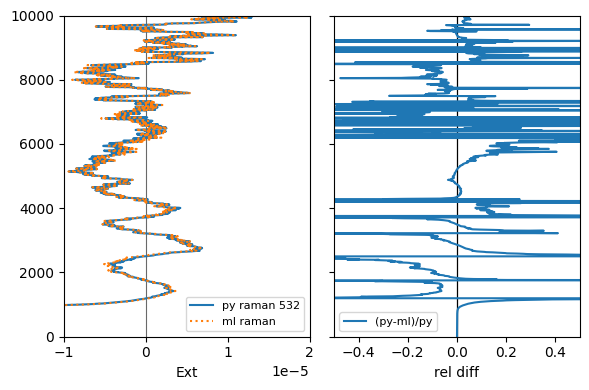

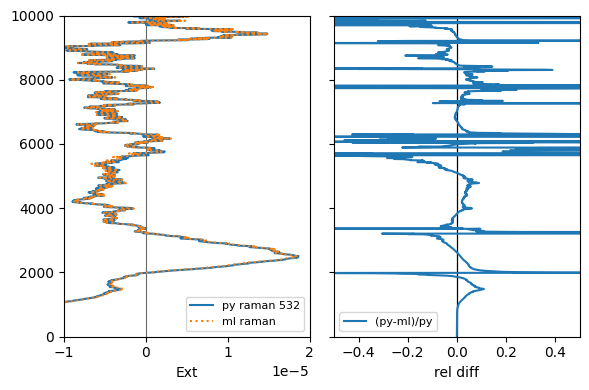

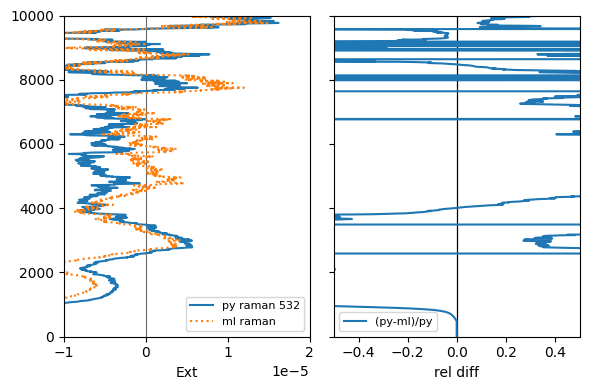

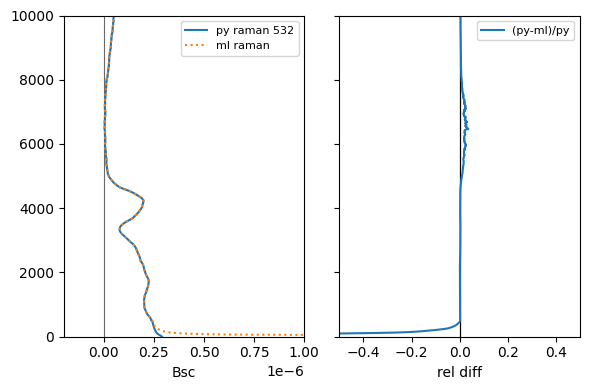

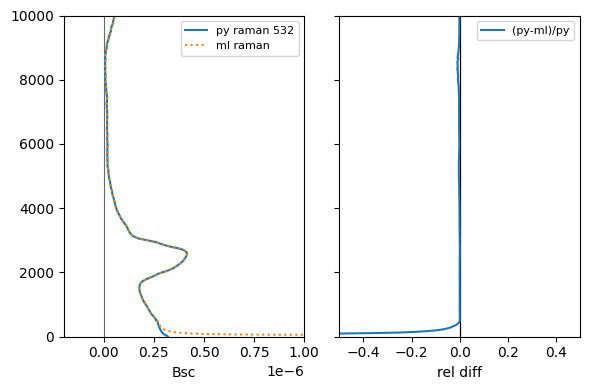

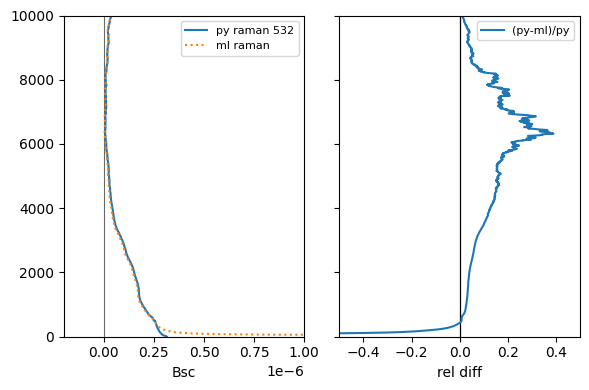

In [75]:

with open('20230618_0000_raman_matlab.pickle', 'rb') as f:
    raman_ml = pickle.load(f)
print(raman_ml.keys())

# for wv in [355,532,1064]:
for wv in [532]:
    for i in range(len(data_cube.data_retrievals['raman'])):

        refHInd = data_cube.refH[i][f"{wv}_total_FR"]['refHInd']
        refH = np.array(data_cube.data_retrievals['height'])[np.array(refHInd)]
        print(refHInd, refH)
           
        ext_py = data_cube.data_retrievals['raman'][i][f'{wv}_total_FR']['aerExt']
        ext_ml = np.array(raman_ml[f'aerExt{wv}_raman'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        #ax.fill_between([-1e-6, np.max(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
        #                color='grey', alpha=0.5)
        ax.plot(ext_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py raman {wv}')
        ax.plot(ext_ml, np.array(raman_ml['height']), 
                color='C1', ls=':', label='ml raman')
        
        ax.set_ylim(0, 10000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel('Ext')
        ax.set_xlim([-0.1e-4, 0.2e-4])
    
        reldiff = (ext_py - ext_ml)/ext_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.5, 0.5); ax1.set_xlabel('rel diff')
        fig.tight_layout()
        # # # fig.savefig('mSig_rayleigh_fit.png')

    
    for i in range(len(data_cube.data_retrievals['raman'])):

        refHInd = data_cube.refH[i][f"{wv}_total_FR"]['refHInd']
        refH = np.array(data_cube.data_retrievals['height'])[np.array(refHInd)]
        print(refHInd, refH)
           
        bsc_py = data_cube.data_retrievals['raman'][i][f'{wv}_total_FR']['aerBsc']
        bsc_ml = np.array(raman_ml[f'aerBsc{wv}_raman'])[i,:]
        fig, (ax, ax1) = plt.subplots(1,2, figsize=(6,4), sharey=True)
        ax.axvline(0, lw=0.8, color='dimgrey')
        #ax.fill_between([-1e-6, np.max(beta_py)], np.array([refH[0], refH[0]]), np.array([refH[1], refH[1]]),
        #                color='grey', alpha=0.5)
        ax.plot(bsc_py, np.array(data_cube.data_retrievals['height']), 
                color='C0', label=f'py raman {wv}')
        ax.plot(bsc_ml, np.array(raman_ml['height']), 
                color='C1', ls=':', label='ml raman')
        
        ax.set_ylim(0, 10000)
        # ax.set_xscale('log')
        ax.legend(fontsize=8)
        ax.set_xlabel('Bsc')
        ax.set_xlim([-0.2e-6, 1e-6])
    
        reldiff = (bsc_py - bsc_ml)/bsc_py
        ax1.axvline(0, lw=0.9, color='k')
        ax1.plot(reldiff, data_cube.data_retrievals['height'], label='(py-ml)/py')
        ax1.legend(fontsize=8)
        # ax1.set_xlim(np.percentile(reldiff, [5,95])); ax1.set_xlabel('rel diff')
        ax1.set_xlim(-0.5, 0.5); ax1.set_xlabel('rel diff')
        fig.tight_layout()
        # # # fig.savefig('mSig_rayleigh_fit.png')
